In [262]:
import numpy as np
import torch
import wandb
import matplotlib.pyplot as plt
from torchsummary import summary
from scipy.spatial.distance import jensenshannon
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
from torchsummary import summary
from torch.utils.data import DataLoader

from ensemblecalibration.sampling import multinomial_label_sampling
from ensemblecalibration.nn_training.sampling import (
    generate_fct_dep_weights,
    gen_polynomial_predictions_ivl_binary,
    sample_uniform_instances
)
from ensemblecalibration.nn_training.model import MLPCalW
from ensemblecalibration.nn_training.dataset import MLPDataset
from ensemblecalibration.nn_training.train import train_mlp, train_one_epoch
from ensemblecalibration.nn_training.losses import SKCELoss, FocalLoss, LpLoss
from ensemblecalibration.calibration.calibration_estimates.ece_kde import (
    get_ece_kde,
    get_bandwidth,
)
from ensemblecalibration.calibration.calibration_estimates.helpers import calculate_pbar
from ensemblecalibration.calibration.minimization import solve_cobyla1D, solve_cobyla2D
from ensemblecalibration.calibration.config import config_p_value_analysis, config_new_mlp_binary

# Ensemble Model for Binary Classification: 
### MLP training to predict the optimal convex combination

Sample data points for training and validation, as well as probabilitic predictions, and an optimal convex combination which uses a fixed function taking the instance values as arguments. 

The labels are then sampled from the categorical distribution induced by the predicted probabilities of the convex combination.

Precisely, the sampling process is as follows:

isntances $$ X \sim Unif([0,1])$$ arer generated from the $D$-dim. hypercube. The probabilistic predicitons are then sampled from a Beta distribution induced by the instances: $$\Big(\hat{p}^{(m)}(x_i)\Big)_1 \sim Beta(x_i, s \cdot x_i) \quad \forall i=1, \dots, N, m=1, \dots, M$$, or equivalently $$ \hat{p}^{(m)} \sim Dir([x_i, s \cdot x_i]) \quad \forall i=1, \dots, N, m=1, \dots, M$$
 

$x_i = \alpha_1$
$s \cdot x_i = \alpha_0 - \alpha_1$
$\alpha_0 = (s +1) \cdot x_i$

In [263]:


# data parameters
N_SAMPLES_TRAIN = 10000
N_SAMPLES_VAL = 5000
N_ENS = 2
lower_bound_inst = 0
upper_bound_inst = 1
# degree of the function which is used to generate the weights, in dependence of the instances
deg_weights = 1
# scale factor for the Beta dsitribution
scale_factor = 5
# whether the ensemble predictions are dependent on the ensemble member
ens_dep = True
# train parameters
N_EPOCHS = 100
LR = 0.0001
# learning rate scheduler
lr_scheduler = ReduceLROnPlateau
lr_scheduler_cyclic = CyclicLR
# batch size for training loop
BATCH_SIZE = 1000
# bandwidth used for SKCE loss (in distance measure used in the kernel)
BW = 0.01
# band width for Lp calibration error (can be None if it has to be determined empirically)
bw_lp = 0.01
# squared kernel calibration error loss
loss_skce = SKCELoss(bw=BW)
# L2 loss
loss_l2 = LpLoss(p=2, bw=bw_lp)
loss_l1 = LpLoss(p=1, bw=bw_lp)
# focal loss
loss_focal = FocalLoss()

optimizer = torch.optim.Adam
# number of different models to train
N_ITER = 5

# model parameters
N_HIDDEN = 32
N_HIDDEN_LAYERS = 1


### sample instances for training and validation uniformly from the unit interval:

In [264]:
# sample instances from the uniform distribution
x_train = sample_uniform_instances(n_samples=config["N_SAMPLES_TRAIN"], x_lower=0, x_upper=1)
x_val = sample_uniform_instances(n_samples=config["N_SAMPLES_VAL"], x_lower=0, x_upper=1)


#### Analyze the Beta distribution from which the predictions are sampled from:

As we have $\hat{p}^{(m)}(x_i) \sim Beta(x_i, s \cdot x_i )$, we fill first analyze the behavior of the Beta distribution 
with respect to the parameter $s$.
As an example, we visualize the empirical distribution of predicted probabilities for the first (blue) and
second class for the case $$s=2$$.

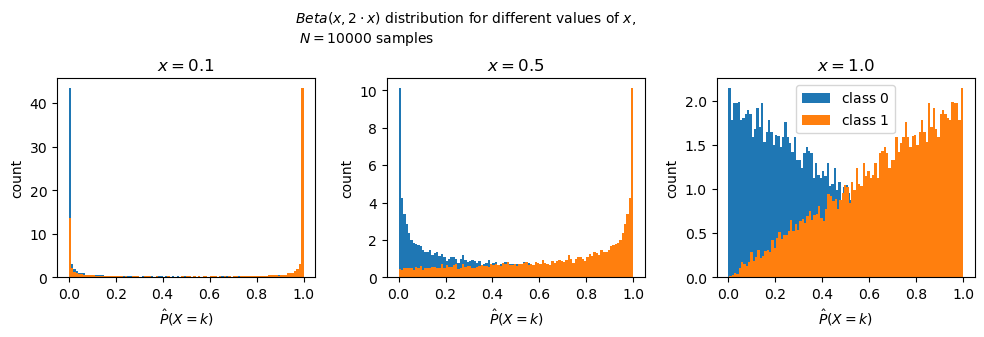

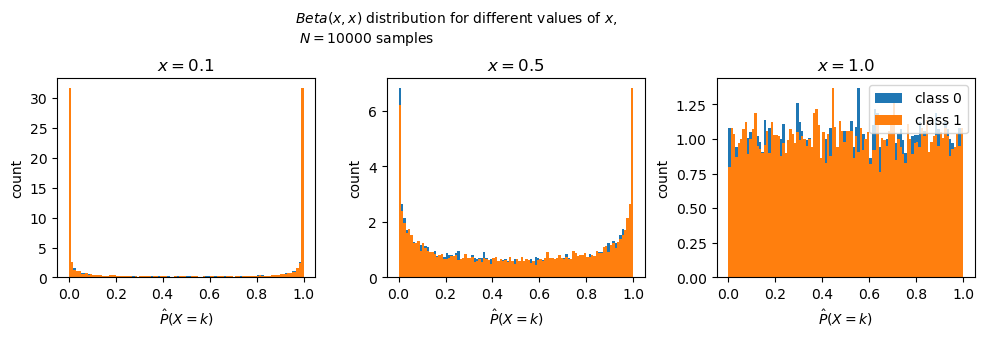

In [265]:
s = 2
x = [0.1, 0.5, 1.0]
fig, ax = plt.subplots(1,len(x), figsize=(10, 3))

for i, n in enumerate(x):
    # sample from beta distribution
    #x = np.random.beta(0.1 * j, n * (0.1 * j), size=10000)
    preds = np.random.dirichlet([n, s * n], size=10000)
    ax[i].hist(preds[:, 0], bins=100, density=True, label='class $0$')
    ax[i].hist(preds[:, 1], bins=100, density=True, label='class $1$')
    ax[i].set_xlabel("$\hat{P}(X=k)$")
    ax[i].set_title(f"$x={{{n}}}$")
    ax[i].set_ylabel("count")

plt.tight_layout()
fig.text(0.3, 1.0, "$Beta(x, 2 \cdot x)$ distribution for different values of $x$, \n $N=10000$ samples")
plt.legend()
plt.show()

# now the same for the case s=1
s = 1
x = [0.1, 0.5, 1.0]
fig, ax = plt.subplots(1,len(x), figsize=(10, 3))

for i, n in enumerate(x):
    # sample from beta distribution
    #x = np.random.beta(0.1 * j, n * (0.1 * j), size=10000)
    preds = np.random.dirichlet([n, s * n], size=10000)
    ax[i].hist(preds[:, 0], bins=100, density=True, label='class $0$')
    ax[i].hist(preds[:, 1], bins=100, density=True, label='class $1$')
    ax[i].set_xlabel("$\hat{P}(X=k)$")
    ax[i].set_title(f"$x={{{n}}}$")
    ax[i].set_ylabel("count")

plt.tight_layout()
fig.text(0.3, 1.0, "$Beta(x, x)$ distribution for different values of $x$, \n $N=10000$ samples")
plt.legend()
plt.show()


In [270]:
np.random.dirichlet([1]*2)

array([0.98406853, 0.01593147])

Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "/Users/mirajuergens/opt/miniconda3/envs/calibration/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/mirajuergens/opt/miniconda3/envs/calibration/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mirajuergens/opt/miniconda3/envs/calibration/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 299, in check_internal_messages
    self._loop_check_status(
  File "/Users/mirajuergens/opt/miniconda3/envs/calibration/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 223, in _loop_check_status
    local_handle = request()
  File "/Users/mirajuergens/opt/miniconda3/envs/calibration/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 743, in deliver_internal_messages
    return self._deliver_internal_messages(internal_message)
  File "/Users/mirajuergens/opt/miniconda3/envs/calibration/lib/python3.

## Simplification: See predicted probabilities as a linear function of the instances
In this case we would have a deterministic dependency between the value of the instance $x_i$ and the predicted probabilties for class $1$ and $2$, respectively.
Furthermore, this way we can analyse the distance between the convex combination of prediction and the ensemble predictions in more detail.

We first look at two ensemble member predictions $\hat{p}^{(1)}$ and $\hat{p}^{(2)}$ 
with 
$$ \hat{p}^{(1)}(x)=\begin{pmatrix} 
        0.5x \\
        1 - 0.5 x
        \end{pmatrix}
        $$
and 
$$ \hat{p}^{(2)}(x) = \begin{pmatrix}
        1- 0.5 x \\
        0.5 x
\end{pmatrix}
$$
for $x \in [0,1]$.

The respective convex combination is then given by $$\hat{p}_{\lambda}(x) = \lambda_1 \cdot \hat{p}^{(1)}(x) + \lambda_2 \cdot \hat{p}^{(2)}(x)$$

where $$\lambda = \begin{pmatrix} \lambda_1 \\ \lambda_2 \end{pmatrix} $$
is either a function of $x$ or constant.

In [82]:
def p_1_binary_determ(x: np.ndarray):
    """first binary predictor which predicts the first class with probability 0.5*x
    and the second class with probability 1 - 0.5*x
    """
    n_samples, n_features = x.shape
    preds = np.zeros((n_samples, 2))
    preds[:, 0] = 0.5 * x[:, 0]
    preds[:, 1] = 1 - 0.5 * x[:, 0]
    return preds

def p_2_binary_determ(x: np.ndarray):
    """second binary predictor which 
    predicts the first class with probability 1 - 0.5*x
    and the second class with probability 0.5*x"""
    n_samples, n_features = x.shape
    preds = np.zeros((n_samples, 2))
    preds[:, 0] = 1 - 0.5 * x[:, 0]
    preds[:, 1] = 0.5 * x[:, 0]
    return preds

def binary_ensemble_cone(x: np.ndarray):
    preds_1 = p_1_binary_determ(x)
    preds_2 = p_2_binary_determ(x)

    p_probs = np.stack([preds_1, preds_2], axis=1)
    return p_probs


# convex combination: using a constant weight 
def p_bar_const(p_1: np.ndarray, p_2: np.ndarray, w_1: float = 0.5):
    """function which calculates the convex combination of two binary predictors given the weight of 
    the first predictor"""
    w_2 = 1 - w_1
    return w_1 * p_1 + w_2 * p_2

def p_bar_x_dep(x_inst: np.ndarray, p_probs: np.ndarray, deg_fct: int = 1):
    """function which calculates the convex combination of a number of binary predictors
    using a weight function of a given degree which is dependent on the instances

    Parameters
    ----------
    x_inst : np.ndarray
        array of shape (n_samples, n_features) containing the instances
    p_probs : np.ndarray
        array of shape (n_samples, n_predictors, 2) containing the probabilistic predictions for each
        ensemble member
    deg_fct : int, optional
        , by default 1

    Returns
    -------
    _type_
        _description_
    """
    p_bar = x_inst**deg_fct * p_probs[:, 0, :] + (1 - x_inst**deg_fct) * p_probs[:, 1, :]
    return p_bar




In [83]:
# generate instance dependent predictions for the two predictors
# matrix of shape (n_instances, n_ensembles, n_predictions)
p_probs = binary_ensemble_cone(x_train)

# now for validation data
p_probs_val = binary_ensemble_cone(x_val)

# prediction outside of convex hull (TODO: more profound example)
p_bar_out = np.zeros((x_train.shape[0], 2))
p_bar_out[:,0] = 0.75*x_train[:,0]**2 -0.25*x_train[:,0]
p_bar_out[:,1] = 1- 0.5*x_train[:,0]**2



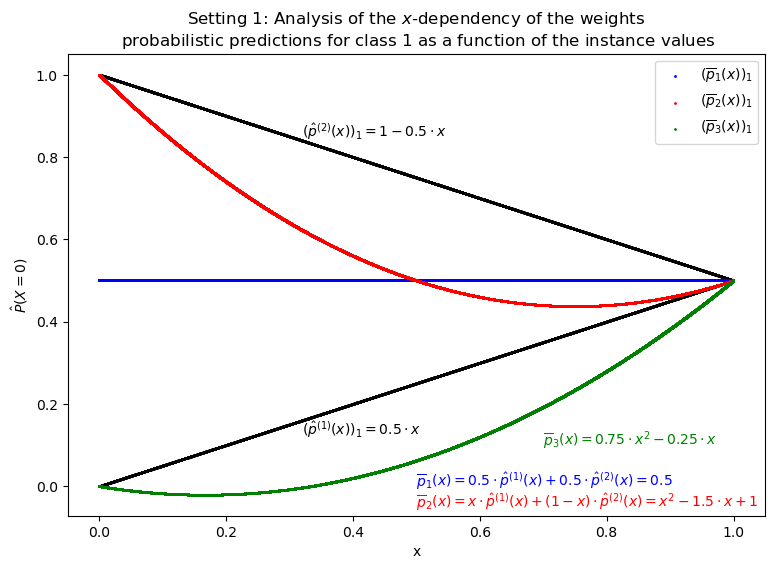

In [76]:
fig, ax = plt.subplots(figsize=(9, 6))
# sort predicted probabilities according to value of instances
x_train_sorted = np.sort(x_train).squeeze()
idx_sorted = np.argsort(x_train)

#scatter plot ensemble predictions 
ax.scatter(x_train.squeeze(), preds_1[:,0], alpha=0.2, s=1, 
           color="black")
ax.scatter(x_train.squeeze(), preds_2[:,0],  alpha=0.2, s=1,
           color="black")
# plot convex combination with constant weights, for w = 0.5

p_bar_w = p_bar_const(preds_1, preds_2, 0.5)
ax.scatter(x_train.squeeze(), p_bar_w[:,0], s=1, c='blue', label='$(\overline{p}_1(x))_1$')

# plot convex combination for instance dependent weights 
# x dependency of weights: plot exemplary for degree 1
deg = 1
p_bar_deg = p_bar_x_dep(x_train, p_probs, deg_fct=deg)
ax.scatter(x_train.squeeze(), p_bar_deg[:,0],  s=1, c='red', label='$(\overline{p}_2(x))_1$')

# now plot the prediction outside the set of all possible convex combinations
ax.scatter(x_train.squeeze(), p_bar_out[:,0], s=1, c="green", label='$(\overline{p}_3(x))_1$')
ax.set_xlabel('x')

ax.set_ylabel('$\hat{P}(X=0)$')
ax.text(0.32, 0.125, "$(\hat{p}^{(1)}(x))_1 = 0.5 \cdot x$", fontsize=10, color='black')
ax.text(0.32, 0.85, "$(\hat{p}^{(2)}(x))_1 = 1 - 0.5 \cdot x$", fontsize=10, color='black')
ax.text(0.5, 0.00, "$\overline{p}_1(x)=0.5 \cdot \hat{p}^{(1)}(x)+0.5 \cdot \hat{p}^{(2)}(x)=0.5$", fontsize=10, color='blue')
ax.text(0.5, -0.05, "$\overline{p}_2(x)= x \cdot \hat{p}^{(1)}(x)+ (1-x) \cdot \hat{p}^{(2)}(x)=x^2 -1.5 \cdot x + 1$", fontsize=10, color='red')
ax.text(0.7, 0.1, "$\overline{p}_3(x) = 0.75 \cdot x^2 - 0.25 \cdot x$", fontsize=10, color='green')

plt.title("Setting 1: Analysis of the $x$-dependency of the weights \n probabilistic predictions for class $1$ as a function of the instance values ")
plt.legend()

### Case 1: learn a constant weight function
In the first case, we examine whether a given model is able to learn constant weights: Here, the calibrated convex combination is given by:
$$ \bar{p}_{\lambda}(x) = 0.5 \cdot \hat{p}^{(1)}(x) + 0.5 \cdot \hat{p}^{(2)}(x) $$

such that the model has to learn the function 
$$ \begin{align*} \hat{\lambda}: \mathcal{X} \longrightarrow \Delta_2 \\ x \mapsto \begin{pmatrix} 0.5 \\ 0.5 \end{pmatrix} \end{align*} $$


### Train a Perceptron to learn the weights:

first we write a train function using the config file defined earlier in order to track different configurations:

In [254]:
def train_mlp_wandb_binary(model, dataset, config):

    optimizer = config["optimizer"](model.parameters(), lr=config["lr"])
    loss = config["loss"]
    dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)
    # train model
    for epoch in range(config["n_epochs"]):
        model.train()
        for (p_probs, y_labels, x_inst) in dataloader:
            p_probs, x_inst = p_probs.float(), x_inst.float()
            optimizer.zero_grad()
            weights_l = model(x_inst)
            loss_train = loss(p_probs, weights_l, y_labels)
            loss_train.backward()
            optimizer.step()



            # log loss and biases
            bias = model.layers[0].bias.data.detach().numpy().squeeze()
            weights = model.layers[0].weight.data.detach().numpy().squeeze()
            wandb.log({"loss": loss_train.item(), "bias 1": bias[0], "bias 2": bias[1],
                       "weight 1": weights[0], "weight 2": weights[1]})
            # print loss
            print(f"Epoch {epoch}, loss: {loss_train.item()}")
            
            
    return model



### config file for the weights and biases documentation:

In [117]:
# set parameters: create a config dictionary

config = {
    "N_SAMPLES_TRAIN": 20000,
    "N_SAMPLES_VAL": 5000,
    "deg_weights": 1,
    "lr": 0.0005,
    "n_epochs": 300,
    "bw": 0.01,
    "batch_size": 1000,
    "loss": LpLoss(p=2, bw=0.01),
    "optimizer": torch.optim.Adam,
    "n_hidden_layers": 0,
    "n_hidden_params": 12
}


In [118]:
# initialize the wandb run
wandb.init(
    project="ensemble-calibration-toy-experiments",
    config= config,
    name="mlp-const-l2-2"
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


bias 1,▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████
bias 2,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▂█▇▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weight 1,█▇█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
weight 2,▁▂▁▂▂▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
bias 1,0.63034
bias 2,0.66437
loss,0.0
weight 1,-0.39249
weight 2,-0.41576


#### initialize the model:

In [119]:
model_const = MLPCalW(in_channels=x_train.shape[1], hidden_dim=config["n_hidden_params"],
                       hidden_layers=config["n_hidden_layers"], use_relu=False,
                       out_channels=2)

### initialize the data:

In [120]:
x_train = sample_uniform_instances(n_samples=config["N_SAMPLES_TRAIN"], x_lower=0, x_upper=1)
p_probs = binary_ensemble_cone(x_train)
# constant weights
weights_l = np.ones((config["N_SAMPLES_TRAIN"], p_probs.shape[1]))*0.5
p_bar = calculate_pbar(weights_l, p_probs)
y_labels = np.apply_along_axis(multinomial_label_sampling, 1, p_bar)

dataset_train = MLPDataset(x_train, p_probs, y_labels)

### train the model:

In [121]:
model_const_trained = train_mlp_wandb_binary(model_const, dataset_train, config)

Epoch 0, loss: 0.005999525543302298
Epoch 0, loss: 0.003982871305197477
Epoch 0, loss: 0.0022088470868766308
Epoch 0, loss: 0.007062808144837618
Epoch 0, loss: 0.00540752150118351
Epoch 0, loss: 0.002738043200224638
Epoch 0, loss: 0.0031687654554843903
Epoch 0, loss: 0.0030574321281164885
Epoch 0, loss: 0.0019617790821939707
Epoch 0, loss: 0.0031368352938443422
Epoch 0, loss: 0.001533602480776608
Epoch 0, loss: 0.006256673019379377
Epoch 0, loss: 0.004658740945160389
Epoch 0, loss: 0.005060629919171333
Epoch 0, loss: 0.0032434454187750816
Epoch 0, loss: 0.005107825621962547
Epoch 0, loss: 0.0052237496711313725
Epoch 0, loss: 0.006366437766700983
Epoch 0, loss: 0.0019982948433607817
Epoch 0, loss: 0.0037044030614197254
Epoch 1, loss: 0.004067222122102976
Epoch 1, loss: 0.007746399845927954
Epoch 1, loss: 0.004581790417432785
Epoch 1, loss: 0.005688323173671961
Epoch 1, loss: 0.0022299226839095354
Epoch 1, loss: 0.000920081278309226
Epoch 1, loss: 0.0018087534699589014
Epoch 1, loss: 0.0

### visualize the predicted convex combination:

In [122]:
weights_pred = model_const(torch.from_numpy(x_train).float())
p_bar_pred = calculate_pbar(weights_pred.detach().numpy(), p_probs)

MAE for constant weights: 0.002517969063774741


Text(0.32, 0.6, 'MAE = 0.003')

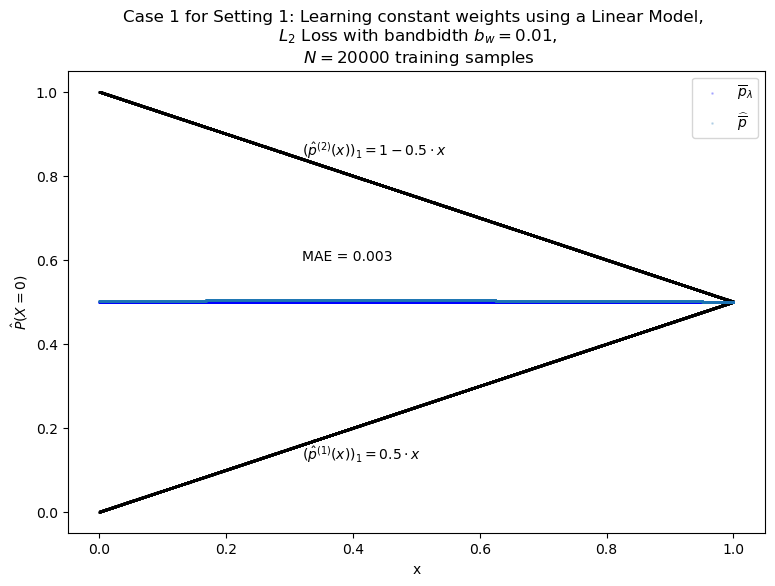

In [124]:
# plot the calculated predicted probabilities vs the real calibrated ones for the constant case
fig, ax = plt.subplots(figsize=(9, 6))

#scatter plot ensemble predictions 
ax.scatter(x_train.squeeze(), p_probs[:,0,0], alpha=0.2, s=1, 
           color="black")
ax.scatter(x_train.squeeze(), p_probs[:,0,1],  alpha=0.2, s=1,
           color="black")
# plot convex combination with constant weights, for w = 0.5
ax.scatter(x_train.squeeze(), p_bar[:, 0], label='$\overline{p}_{\lambda}$', s=1, alpha=0.2, 
           color="blue")
ax.scatter(x_train.squeeze(), p_bar_pred[:, 0], label='$\widehat{\overline{p}}$', s =1,
            alpha=0.2)

ax.set_xlabel('x')

ax.set_ylabel('$\hat{P}(X=0)$')
ax.text(0.32, 0.125, "$(\hat{p}^{(1)}(x))_1 = 0.5 \cdot x$", fontsize=10, color='black')
ax.text(0.32, 0.85, "$(\hat{p}^{(2)}(x))_1 = 1 - 0.5 \cdot x$", fontsize=10, color='black')

plt.title("Case 1 for Setting 1: Learning constant weights using a Linear Model, \n $L_2$ Loss with bandbidth $b_w=0.01$, \n $N=20000$ training samples")
plt.legend()

# now calculate the average distane between calibrated predictions and estimated ones
# ( mean absolute error)
mae_const = np.mean(np.abs(p_bar - p_bar_pred))
print(f"MAE for constant weights: {mae_const}")

ax.text(0.32, 0.6, f"MAE = {mae_const:.3f}", fontsize=10, color='black')


In [126]:
# compare with minimum found by cobyla
params = config_p_value_analysis["SKCEul2"]["params"]
calc_weights_cobyla_const= solve_cobyla1D(p_probs, y_labels, params=params)

mae_cobyla = np.mean(np.abs(calc_weights_cobyla_const - np.array([0.5, 0.5])))
mae_cobyla

7.071067811867393e-05

### Heatmap Analysis: 
Analyse the convexity of the squared kernel calibration error by calculating it as a fucntion of $\lambda_1$.


In [129]:
from ensemblecalibration.calibration.calibration_estimates.skce import skce_ul_obj_lambda
from ensemblecalibration.calibration.calibration_estimates.ece_kde import get_ece_kde, get_bandwidth

# write squared kernel calibration error as a function of the first weight
def skce_binary_lambda(w_1: float, p_probs=p_probs, y_labels=y_labels, bw: float = config["bw"],
                       params=params):
   
    # initialize weight vector
    weights_l = np.zeros((p_probs.shape[0], 2))
    weights_l[:, 0] = w_1
    weights_l[:, 1] = 1 - w_1
    
    skce = skce_ul_obj_lambda(weights_l=weights_l, p_probs=p_probs, y_labels=y_labels,
                              params=params, x_dependency=True)
    
    return skce

def ece_kde_binary_lambda(w_1: float, p_probs=p_probs, y_labels=y_labels, bw= config["bw"]):

    # compute convex combination
    p_bar = w_1 * p_probs[:, 0] + (1 - w_1) * p_probs[:, 1]
    # cahnge to torch tensor
    p_bar, y_labels = torch.from_numpy(p_bar).float(), torch.from_numpy(y_labels).long()
    # calculate bandwidth empiricallly if it is None
    if bw is None:
        bw = get_bandwidth(p_bar, 'cpu')

    # calulate Lp calibration error
    ece_kde = get_ece_kde(p_bar, y_labels, bw, p=1, mc_type='canonical', device='cpu')

    return ece_kde

# vectorized versions of ece_kde_lambda and skce_binary_lambda
ece_kde_binary_lambda_v = np.vectorize(ece_kde_binary_lambda)
skce_binary_lambda_v = np.vectorize(skce_binary_lambda)


calculate miscalibration errors for a number of different weights $w_i$:

In [130]:
l_weights = np.array(np.linspace(0,1,100))
errors_skce_binary = skce_binary_lambda_v(l_weights)
errors_ece_kde_binary = ece_kde_binary_lambda_v(l_weights)

# calulate weight where minimum is reached
min_idx_skce = np.argmin(errors_skce_binary)
min_idx_ece_kde = np.argmin(errors_ece_kde_binary)

min_weight_skce = l_weights[min_idx_skce]
min_weight_ece_kde = l_weights[min_idx_ece_kde]

plot the miscalibration errors as a function of $w_1$:

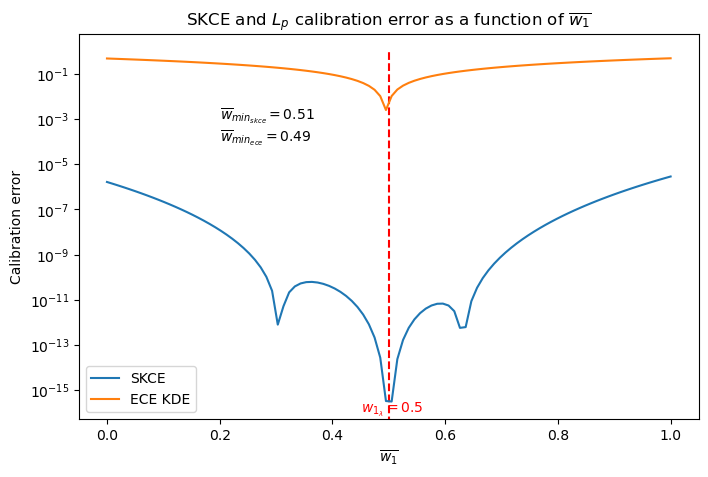

In [132]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(l_weights, errors_skce_binary, label='SKCE')
ax.plot(l_weights, errors_ece_kde_binary, label='ECE KDE')

# log scale y axis
ax.set_yscale('log')
ax.set_xlabel('$\overline{w_1}$')
ax.set_ylabel('Calibration error')

ax.text(.2, .001, f'$\overline{{w}}_{{min_{{skce}}}} = {{{np.round(min_weight_skce, 2)}}}$')
ax.text(.2, .0001, f'$\overline{{w}}_{{min_{{ece}}}} = {{{np.round(min_weight_ece_kde, 2)}}}$')
ax.vlines(0.5, ymin=0, ymax=1, linestyle='--', color='red')
ax.text(0.45, 1e-16, '$w_{1_{\lambda}} = 0.5$', color="red")

plt.title("SKCE and $L_p$ calibration error as a function of $\overline{w_1}$")

plt.legend()

Text(0.5, 1.0, '$L_p$ calibration error as a function of $w_1$')

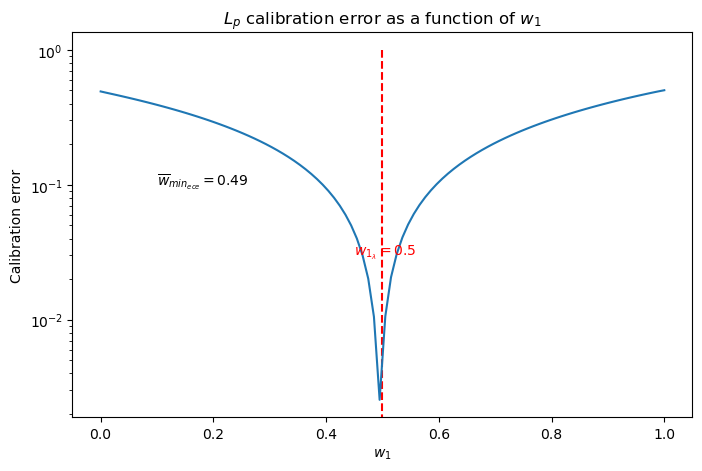

In [134]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(l_weights, errors_ece_kde_binary, label='ECE KDE')

# log scale y axis
ax.set_yscale('log')
ax.set_xlabel('$w_1$')
ax.set_ylabel('Calibration error')

ax.text(.1, .1, f'$\overline{{w}}_{{min_{{ece}}}} = {{{np.round(min_weight_ece_kde, 2)}}}$')
ax.text(0.45, 0.3e-1, '$w_{1_{\lambda}} = 0.5$', color="red")
ax.vlines(0.5, ymin=0, ymax=1, linestyle='--', color='red')
plt.title("$L_p$ calibration error as a function of $w_1$")


## Case 2: Learn an instance dependent convex combination

In the second case, the calibrated convex combination is given by:

$$ \overline{p}_{\lambda}(x) = x \cdot \hat{p}^{(1)}(x) + (1 - x) \cdot \hat{p}^{(2)}(x) $$

i.e. the function to bea learned is 

$$ \begin{align*} \lambda: \mathcal{X} \longrightarrow \Delta_2 \\ x \mapsto \begin{pmatrix} x \\ 1 - x \end{pmatrix} \end{align*} $$

As we use a Perceptron with only 2 weights and two bias terms, the model should learn the optimal weights

$$ \mathbf{w} = \begin{pmatrix} w_1 \\
w_2 \end{pmatrix} = \begin{pmatrix}
1 \\ -1
\end{pmatrix}
$$
and 
$$ \mathbf{b} = \begin{pmatrix}
b_1 \\
b_2 \end{pmatrix} = \begin{pmatrix}
0 \\
1 \end{pmatrix}. $$


### create config file for documentation

In [255]:

config = {
    "N_SAMPLES_TRAIN": 20000,
    "N_SAMPLES_VAL": 5000,
    "deg_weights": 1,
    "lr": 0.0001,
    "n_epochs": 300,
    "bw": 0.01,
    "batch_size": 5000,
    "loss": LpLoss(p=2, bw=0.01),
    "optimizer": torch.optim.Adam,
    "n_hidden_layers": 0,
    "n_hidden_params": 12
}


### generate dataset

In [256]:
x_train = sample_uniform_instances(n_samples=config["N_SAMPLES_TRAIN"], x_lower=0, x_upper=1)
p_probs = binary_ensemble_cone(x_train)
# constant weights
weights_l = np.zeros((len(x_train), 2))
weights_l[:, 0] = x_train.squeeze()
weights_l[:, 1] = 1- x_train.squeeze()
p_bar = calculate_pbar(weights_l, p_probs)
y_labels = np.apply_along_axis(multinomial_label_sampling, 1, p_bar)

dataset_train = MLPDataset(x_train, p_probs, y_labels)


### initialize the model

In [257]:
# initialize the model: this time, we use no hidden layer, the learned function is again linear
model_x_dep = MLPCalW(in_channels= x_train.shape[1], out_channels=p_probs.shape[1],
                      hidden_dim=config["n_hidden_params"], hidden_layers=config["n_hidden_layers"], use_relu=False)

### initialize wandb

In [258]:
wandb.init(
    project="ensemble-calibration-toy-experiments-linear",
    config= config,
    name="mlp-linear-l2-0.0001"
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


bias 1,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
bias 2,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
loss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
loss_real,▁
weight 1,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
weight 2,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
bias 1,-0.81097
bias 2,-0.2582
loss,0.00351
loss_real,0.00034
weight 1,-0.41283


In [259]:
model_trained_x_dep = train_mlp_wandb_binary(model_x_dep, dataset_train, config)

Epoch 0, loss: 0.09364426136016846
Epoch 0, loss: 0.10354394465684891
Epoch 0, loss: 0.10131920874118805
Epoch 0, loss: 0.0908018946647644
Epoch 1, loss: 0.09698383510112762
Epoch 1, loss: 0.09865745902061462
Epoch 1, loss: 0.10318631678819656
Epoch 1, loss: 0.08974964171648026
Epoch 2, loss: 0.0942457988858223
Epoch 2, loss: 0.09402202814817429
Epoch 2, loss: 0.09662792831659317
Epoch 2, loss: 0.10274693369865417
Epoch 3, loss: 0.09570465981960297
Epoch 3, loss: 0.09195638447999954
Epoch 3, loss: 0.09986913949251175
Epoch 3, loss: 0.09950808435678482
Epoch 4, loss: 0.09240822494029999
Epoch 4, loss: 0.09214186668395996
Epoch 4, loss: 0.09460845589637756
Epoch 4, loss: 0.107888363301754
Epoch 5, loss: 0.09090063720941544
Epoch 5, loss: 0.1046120822429657
Epoch 5, loss: 0.09614769369363785
Epoch 5, loss: 0.09434542059898376
Epoch 6, loss: 0.09744757413864136
Epoch 6, loss: 0.10303248465061188
Epoch 6, loss: 0.09163464605808258
Epoch 6, loss: 0.09320329874753952
Epoch 7, loss: 0.08963026

In [260]:
# calculate predeicted weights and convex combination
calc_weights_model_x_dep = model_trained_x_dep(torch.from_numpy(x_train).float())
calc_p_bar_model_x_dep = calculate_pbar(calc_weights_model_x_dep.detach().numpy(), p_probs)


compare with loss of calibrated convex combination:

In [261]:
loss_real = config["loss"](torch.from_numpy(p_probs).float(), torch.from_numpy(weights_l).float(),torch.from_numpy( y_labels))
loss_calc = config["loss"](torch.from_numpy(p_probs).float(), calc_weights_model_x_dep.float(), torch.from_numpy(y_labels))

print(f"loss_real: {loss_real}")
print(f"loss_calc: {loss_calc}")

# log loss
wandb.log({"loss_real": loss_real.item()})

loss_real: 0.0004358069854788482
loss_calc: 0.056745875626802444


wandb: Network error (ConnectionError), entering retry loop.


In [186]:
np.abs(np.mean(calc_weights_model_x_dep.detach().numpy() - weights_l))
p_bar = calculate_pbar(weights_l, p_probs)

(p_bar - calc_p_bar_model_x_dep)[:, 0].max()

0.39130290553461167

Text(0.5, 1.0, 'Case 2 for Setting 1: learning an instance dependent function, \n $L_2$ loss')

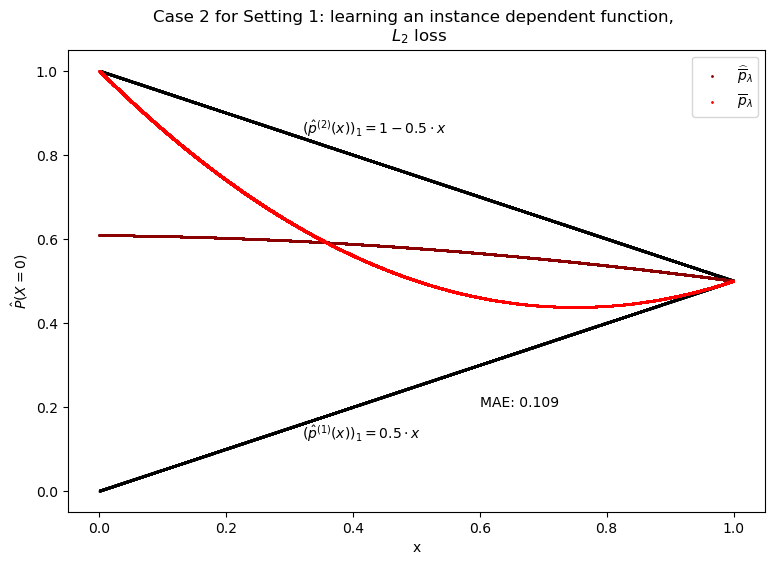

In [187]:
fig, ax = plt.subplots(figsize=(9, 6))

#scatter plot ensemble predictions 
ax.scatter(x_train.squeeze(), p_probs[:,0, 0], alpha=0.2, s=1, 
           color="black")
ax.scatter(x_train.squeeze(), p_probs[:,0,1],  alpha=0.2, s=1,
           color="black")

ax.scatter(x_train.squeeze(), calc_p_bar_model_x_dep[:,0], label = '$\widehat{\overline{p}}_{\lambda}$', 
           s=1, color="darkred")
ax.scatter(x_train.squeeze(), p_bar[:,0], s=1,  c='red', label='$\overline{p}_{\lambda}$')

plt.legend()

ax.set_xlabel('x')

mae = np.mean(np.abs(calc_p_bar_model_x_dep[:,0] - p_bar[:,0]))


ax.set_ylabel('$\hat{P}(X=0)$')
ax.text(0.32, 0.125, "$(\hat{p}^{(1)}(x))_1 = 0.5 \cdot x$", fontsize=10, color='black')
ax.text(0.32, 0.85, "$(\hat{p}^{(2)}(x))_1 = 1 - 0.5 \cdot x$", fontsize=10, color='black')
ax.text(.6, .2, f"MAE: {mae:.3f}", fontsize=10, color='black')

plt.title("Case 2 for Setting 1: learning an instance dependent function, \n $L_2$ loss")

### visualize loss for different kinds of (linear) functions

In [233]:
def get_loss_quadratic_fct(x_inst, y_labels, coef_1: float, coef_2: float, loss, **kwargs):

    # thirs coefficients: 
    coef_3 = .5 - coef_1 - coef_2

    # calculate predictions for the instances
    p_pred = np.zeros((x_inst.shape[0], 2))
    p_pred[:, 0] = coef_1 * x_inst.squeeze() + coef_2 * x_inst.squeeze() + coef_3 * x_inst.squeeze()
    p_pred[:, 1] = 1 - p_pred[:, 0]

    p_pred = torch.from_numpy(p_pred).float()
    # calculate loss
    loss = loss(p_pred, y_labels, **kwargs)

    return loss



In [240]:
get_loss_quadratic_fct(x_train, torch.from_numpy(y_labels), 1, -10.5, loss=get_ece_kde, bandwidth=0.1, p=2, mc_type="canonical", device="cpu")

tensor(0.4046)

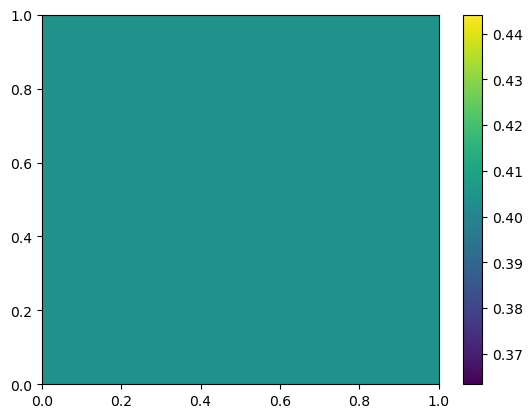

In [224]:

x, y = np.linspace(0, 1, 50), np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)

def f(x,y):

    return get_loss_quadratic_fct(x_train, torch.from_numpy(y_labels), x, y, loss=get_ece_kde, bandwidth=0.01, p=2, mc_type="canonical", device="cpu").item()

Z = np.array([f(x,y) for (x,y) in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
plt.pcolor(X, Y, Z)
plt.colorbar()
plt.show()

In [31]:
# compare with learned weights by cobyla
# compare with minimum found by cobyla
params = config_p_value_analysis["SKCEul2"]["params"]
calc_weights_cobyla_x_dep= solve_cobyla1D(p_probs, y_labels, params=params)
calc_weights_cobyla_x_dep

array([0.49992929, 0.50007071])

### training with $L_1$ miscalibration loss:

In [137]:
# initialize the model: this time, we use no hidden layer, the learned function is again linear
model_x_dep = MLPCalW(in_channels= x_train.shape[1], out_channels=p_probs.shape[1],
                      hidden_dim=12, hidden_layers=0, use_relu=False)

In [133]:
#3 now train with L1 loss
model_x_dep_l2, loss_lp_x_dep, loss_val_l1_x_dep= train_mlp(model_x_dep, dataset_x_dep, 
                                                               dataset_val=dataset_val_x_dep, 
                                                               loss=loss_l1,
                                                                n_epochs=100,
                                                              lr=0.001, batch_size=5000,
                                                                every_n_epoch=10,
                                                                save_best_model=True

                                                    )    

Epoch: 9 train loss: 0.11820874735713005 val loss: 0.10454675555229187 
 lr: 0.001
Epoch: 19 train loss: 0.11411866545677185 val loss: 0.0999484658241272 
 lr: 0.001
Epoch: 29 train loss: 0.10907589644193649 val loss: 0.0950123742222786 
 lr: 0.001
Epoch: 39 train loss: 0.10353380814194679 val loss: 0.0895688384771347 
 lr: 0.001
Epoch: 49 train loss: 0.09732541814446449 val loss: 0.08351384103298187 
 lr: 0.001
Epoch: 59 train loss: 0.09042472392320633 val loss: 0.07670775055885315 
 lr: 0.001
Epoch: 69 train loss: 0.08236423879861832 val loss: 0.06923738867044449 
 lr: 0.001
Epoch: 79 train loss: 0.074376180768013 val loss: 0.06169505789875984 
 lr: 0.001
Epoch: 89 train loss: 0.07278652861714363 val loss: 0.05845016613602638 
 lr: 0.001
Epoch: 99 train loss: 0.06618675217032433 val loss: 0.05864337831735611 
 lr: 0.001


In [123]:
# calculate real los, (1,1))
summary(model_x_dep_l2, (1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 2]               4
           Softmax-2                    [-1, 1]               0
Total params: 4
Trainable params: 4
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [149]:
weight_x_dep_l2 = model_x_dep_l2.layers[0].weight.data
bias_x_dep_l2 = model_x_dep_l2.layers[0].bias.data

# weights of initial model
weights_x_dep = model_x_dep.layers[0].weight.data
bias_x_dep = model_x_dep.layers[0].bias.data

print(f"Weights: {weight_x_dep_l2}")
print(f"Bias: {bias_x_dep_l2}")

print(f"Weights intial: {weights_x_dep}")
print(f"Bias intial: {bias_x_dep}")

Weights: tensor([[ 0.7550],
        [-0.0306]])
Bias: tensor([-0.1814,  0.3875])
Weights intial: tensor([[-0.8157],
        [ 0.2916]])
Bias intial: tensor([0.4551, 0.7404])


In [141]:
l_weights_x_dep

array([[0.46241939, 0.53758061],
       [0.5211488 , 0.4788512 ],
       [0.71317443, 0.28682557],
       ...,
       [0.40411947, 0.59588053],
       [0.18184026, 0.81815974],
       [0.60260042, 0.39739958]])

In [143]:
# compare with loss of calibrated model
loss_real = loss_l2(torch.from_numpy(p_probs), torch.from_numpy(l_weights_x_dep), torch.from_numpy(y_labels))

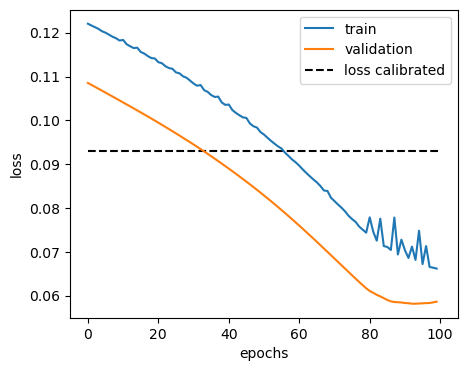

In [144]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

plt.plot(loss_lp_x_dep, label='train')
plt.plot(loss_val_l1_x_dep, label='validation')
# plot real loss
ax.hlines(loss_real_x_dep, 0, len(loss_lp_x_dep), label='loss calibrated', color='black', linestyles='dashed')

ax.set_xlabel('epochs')
ax.set_ylabel('loss')

plt.legend()

Text(0, 0.5, 'loss')

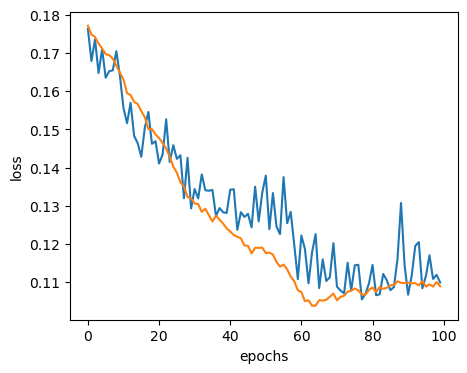

In [41]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

plt.plot(loss_lp_x_dep, label='train')
plt.plot(loss_val_l1_x_dep, label='validation')

ax.set_xlabel('epochs')
ax.set_ylabel('loss')


In [155]:

calc_weights_model_x_dep_l1 = model_x_dep_l2(torch.from_numpy(x_train).float())
calc_p_bar_model_x_dep_1 = calculate_pbar(calc_weights_model_x_dep_l1.detach().numpy(), p_probs)
p_bar_x_dep.shape

(10000, 2)

Text(0.5, 1.0, 'Case 2 for Setting 1: learning an instance dependent function')

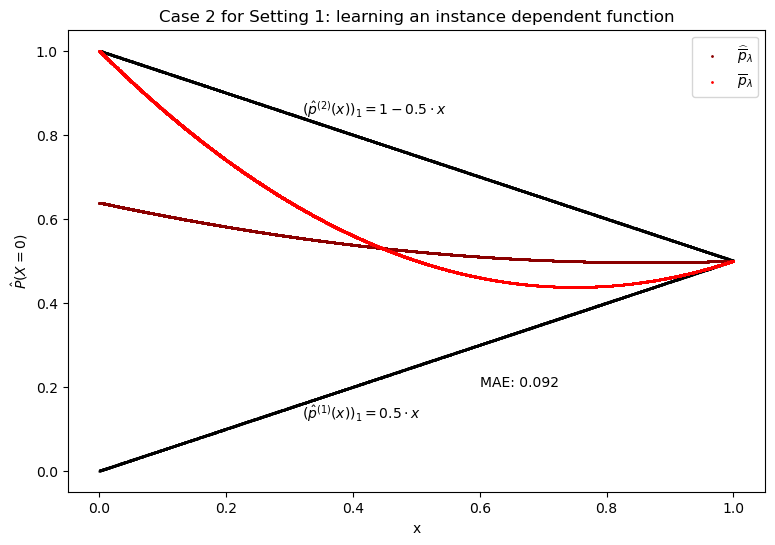

In [156]:
fig, ax = plt.subplots(figsize=(9, 6))

#scatter plot ensemble predictions 
ax.scatter(x_train.squeeze(), preds_1[:,0], alpha=0.2, s=1, 
           color="black")
ax.scatter(x_train.squeeze(), preds_2[:,0],  alpha=0.2, s=1,
           color="black")

ax.scatter(x_train.squeeze(), calc_p_bar_model_x_dep_1[:,0], label = '$\widehat{\overline{p}}_{\lambda}$', 
           s=1, color="darkred")
plt.scatter(x_train.squeeze(), p_bar_x_dep[:,0], s=1,  c='red', label='$\overline{p}_{\lambda}$')
plt.legend()

ax.set_xlabel('x')

mae = np.mean(np.abs(calc_p_bar_model_x_dep_1[:,0] - p_bar_x_dep[:,0]))


ax.set_ylabel('$\hat{P}(X=0)$')
ax.text(0.32, 0.125, "$(\hat{p}^{(1)}(x))_1 = 0.5 \cdot x$", fontsize=10, color='black')
ax.text(0.32, 0.85, "$(\hat{p}^{(2)}(x))_1 = 1 - 0.5 \cdot x$", fontsize=10, color='black')
ax.text(.6, .2, f"MAE: {mae:.3f}", fontsize=10, color='black')

plt.title("Case 2 for Setting 1: learning an instance dependent function")

In [84]:
# compare with real loss
loss_real_x_dep = loss_l1(p_probs, torch.from_numpy(l_weights_x_dep), torch.from_numpy(y_labels_x_dep))
loss_fake = loss_l1(p_probs, calc_weights_model_x_dep_l1.detach(), torch.from_numpy(y_labels_x_dep))
print(loss_real_x_dep)
print(loss_fake)

tensor(0.0930)
tensor(0.1040)


In [158]:
p_bar_test = np.array([[1, 0], [0, 1]])
y_test = np.apply_along_axis(multinomial_label_sampling, 1, p_bar_test)
y_test

array([0, 1])

In [45]:
y_labels_x_dep - y_labels_const

array([ 0,  1,  1, ..., -1, -1, -1])

In [105]:
params = config_p_value_analysis["SKCEul2"]["params"]
params["x_dependency"] = True
print(params)
# compare with weights calculated by Cobyla
calc_weights_cobaly_x_dep = solve_cobyla1D(p_probs, y_labels_x_dep, params=params )
calc_weights_cobaly_x_dep

{'take_square': True, 'n_predictors': 100, 'l_prior': 1, 'optim': 'cobyla', 'n_resamples': 1000, 'dist': <function tv_distance at 0x7faa699a8ca0>, 'sigma': 2.0, 'test': <function skceul at 0x7faa699aeaf0>, 'obj': <function skce_ul_obj at 0x7faa699ae8b0>, 'obj_lambda': <function skce_ul_obj_lambda at 0x7faa699aeca0>, 'sampling': 'lambda', 'transform': 'isometric', 'x_dependency': True, 'alpha': 0.05}


array([0.49992929, 0.50007071])

TODO: compare with minimum found by Cobyla!!

### Case 3: no calibrated convex combination
In the last case we investigate the situation where there is no calibrated convex combination. As an exemplary function, we use

$$ \overline{p}(x) = 

### train an MLP to learn the respective weights of the convex combination:
First, we need to create a dataset for each of the respective probabilistic predictions and ensmeble predictions.
To this end, we need to sample the labels from the Categorical distribution induced by the chosen $\overline{p}$.

In [ ]:
# chose parameters fro training
LR = 0.01
N_EPOCHS = 1000


In [348]:
import copy
# first dataset: constant weights to learn
# sample labels from categorical distribution
y_labels_1 = np.apply_along_axis(multinomial_label_sampling, 1, p_bar_1)
y_labels_2 = np.apply_along_axis(multinomial_label_sampling, 1, p_bar_2)
y_labels_3 = np.apply_along_axis(multinomial_label_sampling, 1, p_bar_3)

# initialize datasets
dataset_1 = MLPDataset(x_train, p_probs, y_labels_1)
dataset_2 = MLPDataset(x_train, p_probs, y_labels_2)
dataset_3 = MLPDataset(x_train, p_probs, y_labels_3)

# initialize models
model_1 = MLPCalW(
        in_channels=x_train.shape[1],
        out_channels=N_ENS,
        hidden_dim=N_HIDDEN,
        hidden_layers=N_HIDDEN_LAYERS,
        use_relu=True,
    )

model_2 = copy.deepcopy(model_1)
model_3 = copy.deepcopy(model_1)

model_1, loss_train_1, loss_val = train_mlp(
    model_1,
    dataset_train=dataset_1,
    n_epochs=N_EPOCHS,
    lr=LR,
    batch_size=BATCH_SIZE,
    loss=loss_l2,
    every_n_epoch=10,
    optim=optimizer,
    shuffle=True
)


model_2, loss_train_2, loss_val = train_mlp(
    model_2,
    dataset_train=dataset_2,
    n_epochs=N_EPOCHS,
    lr=LR,
    batch_size=BATCH_SIZE,
    loss=loss_skce,
    every_n_epoch=10,
    optim=optimizer,
)

model_3, loss_train_3, loss_val = train_mlp(
    model_3,
    dataset_train=dataset_3,
    n_epochs=N_EPOCHS,
    lr=LR,
    batch_size=BATCH_SIZE,
    loss=loss_skce,
    every_n_epoch=10,
    optim=optimizer,
)



AssertionError: 

In [359]:
p_probs.sum(axis=2)

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

plot losses for training data for each of the 3 probabilistic predictors that are learned by the model

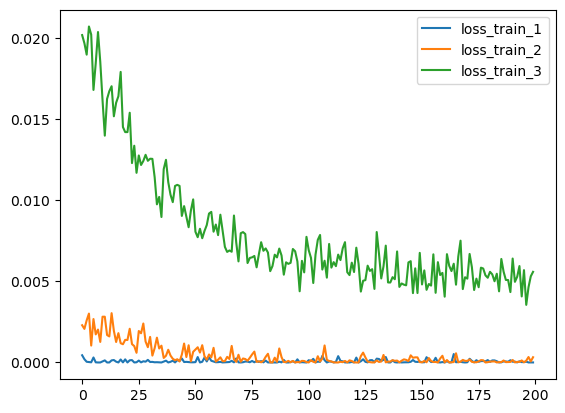

In [153]:
plt.plot(loss_train_1, label='loss_train_1')
plt.plot(loss_train_2, label='loss_train_2')
plt.plot(loss_train_3, label='loss_train_3')
plt.legend()

Text(0.5, 1.0, 'SKCE Loss per epoch for different calibrated predictors, \n MLP model')

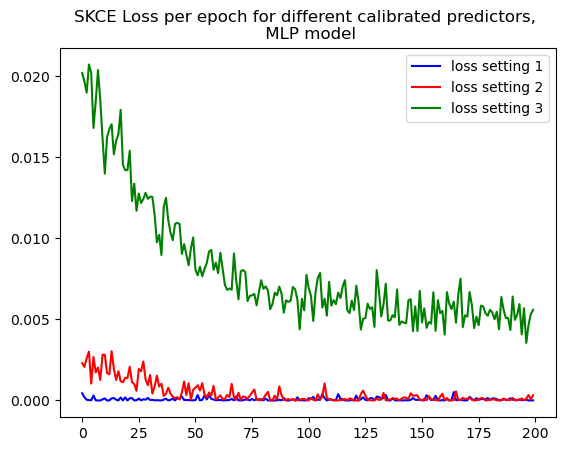

In [154]:
# compare with real loss

plt.plot(loss_train_1, label='loss setting 1', color="blue")
plt.plot(loss_train_2, label='loss setting 2', color="red")
plt.plot(loss_train_3, label='loss setting 3', color="green")
plt.legend()

plt.title("SKCE Loss per epoch for different calibrated predictors, \n MLP model")

In [190]:
pred_weights_1 = model_1(torch.from_numpy(x_train).float())
pred_weights_2 = model_2(torch.from_numpy(x_train).float())
pred_weights_3 = model_3(torch.from_numpy(x_train).float())

# compute calculated predictions
p_bar_pred_1 = calculate_pbar(pred_weights_1.detach().numpy(), p_probs)
p_bar_pred_2 = calculate_pbar(pred_weights_2.detach().numpy(), p_probs)
p_bar_pred_3 = calculate_pbar(pred_weights_3.detach().numpy(), p_probs)


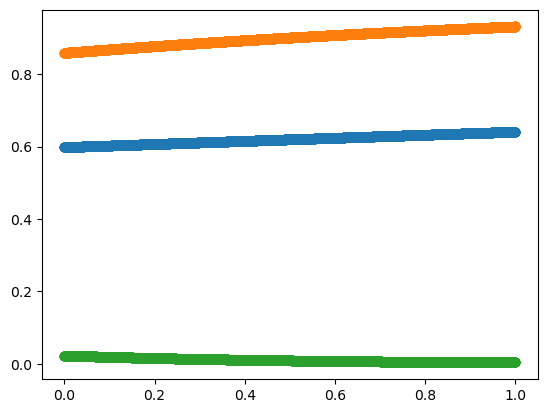

In [191]:
plt.scatter(x_train.squeeze(), pred_weights_1[:,0].detach().numpy(), label="pred_weights_1")
plt.scatter(x_train.squeeze(), pred_weights_2[:,0].detach().numpy(), label="pred_weights_2")
plt.scatter(x_train.squeeze(), pred_weights_3[:,0].detach().numpy(), label="pred_weights_3")

Text(0.5, 1.0, 'Learned predictions for class 1 \n given the learned weights of each trained model')

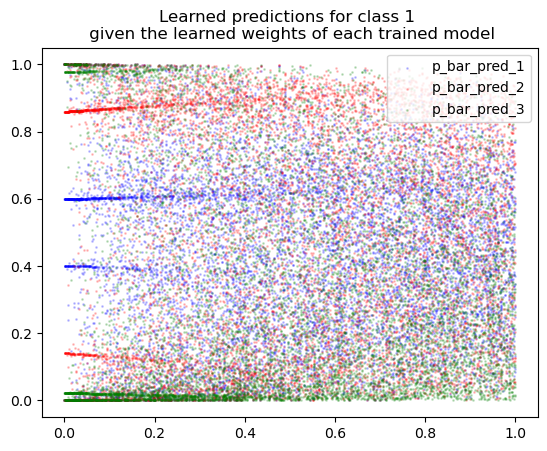

In [194]:
# plot calculated predictions in scatrtter plot

plt.scatter(x_train.squeeze(), p_bar_pred_1[:,0], s=1, label='p_bar_pred_1', alpha=0.2, color="blue")
plt.scatter(x_train.squeeze(), p_bar_pred_2[:,0], s=1, label='p_bar_pred_2', alpha=0.2, color="red")
#plt.scatter(x_train.squeeze(), p_bar_2[:, 0], s=1, label='p_bar_2', alpha=0.2, color="")
plt.scatter(x_train.squeeze(), p_bar_pred_3[:,0], s=1, label='p_bar_pred_3', alpha=0.2, color="green")

plt.legend()
plt.title("Learned predictions for class 1 \n given the learned weights of each trained model")

# Simplification for the alternative hypothesis: Usage of prediction intervals

In order to analyze the case where the "optimal", calibrated predictor lies outside the convex 
set of all convex comibainations of the ensemble predictors, we generate random functions in predefined intervals: For a first, simple experiment, we look at the case at $M=2$ and two disjoint intervals, 
$[c_{00}, c_{01}]$, and $[c_{10}, c_{11}]$. 



In [301]:
# data params
N_INST = 10000
N_PREDS = 2
X_LOWER = 0
X_UPPER = 1
DEG_FCT_PREDS = 1 # degree of polynomial which determines the probabilistic predictions of each ens member

# intervals for predictions
C_00 = 0
C_01 = 0.2
C_10 = 0.4
C_11 = 0.6

# interval for H1
C_20 = 0.7
C_21 = 0.9

DEG_WEIGHTS = 1 # degree of 

In [302]:
# generate univariate instances unifromly in unite interval
x_inst = sample_uniform_instances(n_samples=N_INST, x_lower=X_LOWER, x_upper=X_UPPER, n_dim=1)

In [303]:
# sample deterministic predictions in two intervals
preds_1 = np.zeros((N_INST, 2))
preds_2 = np.zeros((N_INST, 2))
preds_1[:, 0] = gen_polynomial_predictions_ivl_binary(x_inst=x_inst, a_lower=C_00, b_upper=C_01,
                                                deg_fct=1)
preds_1[:, 1] = 1 - preds_1[:, 0]
preds_2[:, 0] = gen_polynomial_predictions_ivl_binary(x_inst=x_inst, a_lower=C_10, b_upper=C_11,
                                                deg_fct=1)
preds_2[:, 1] = 1 - preds_2[:, 0]

# save predictions in one matrix
p_probs = np.stack([preds_1, preds_2], axis=1).reshape(N_INST, 2, -1)

# sample weights
weights = generate_fct_dep_weights(x_inst=x_inst, p_probs=p_probs, deg=1
                                   )
p_bar_1 = calculate_pbar(weights_l=weights, P=p_probs)
p_bar_2 = p_bar_const(preds_1, preds_2)

# predictions outside convex hull of ensemble predictions
p_bar_3 = np.zeros((N_INST, 2))
p_bar_3[:, 0] = gen_polynomial_predictions_ivl_binary(x_inst=x_inst, a_lower=C_20, b_upper=C_21,
                                                deg_fct=1)
p_bar_3[:, 1] = 1 - p_bar_3[:, 0]

plot the probabilities for class $1$ for each ensemble member:

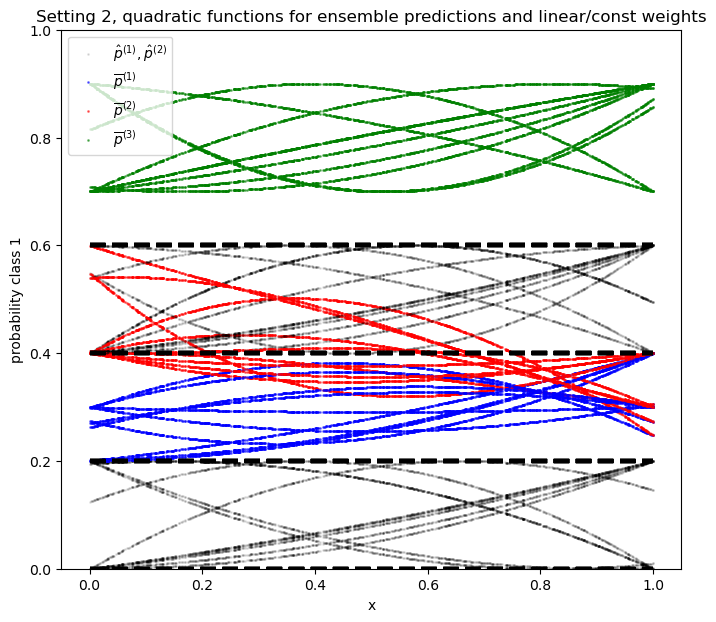

In [274]:
DEG_ENS = 2
DEG_WEIGHTS = 1

fig, ax = plt.subplots(1, 1, figsize=(8, 7))

for n in range(10):
    preds_1 = gen_polynomial_predictions_ivl_binary(x_inst=x_inst, a_lower=C_00, b_upper=C_01,
                                                    deg_fct=DEG_ENS)
    preds_2 = gen_polynomial_predictions_ivl_binary(x_inst=x_inst, a_lower=C_10, b_upper=C_11,
                                                    deg_fct=DEG_ENS)
    if n == 0:
        ax.scatter(x_inst.squeeze(), preds_1, color="black", alpha=0.1, s=1, label="$\hat{p}^{(1)}, \hat{p}^{(2)}$")
        ax.scatter(x_inst.squeeze(), preds_2, color="black", alpha=0.1, s=1)
    
    ax.scatter(x_inst.squeeze(), preds_1, color="black", alpha=0.1, s=1)
    ax.scatter(x_inst.squeeze(), preds_2, color="black", alpha=0.1, s=1)
    # interval boundaries
    ax.hlines(y=C_00, xmin=0, xmax=1, color="black", linestyle="--", alpha=1, lw=3)
    ax.hlines(y=C_01, xmin=0, xmax=1, color="black", linestyle="--", alpha=1, lw=3)
    ax.hlines(y=C_10, xmin=0, xmax=1, color="black", linestyle="--", alpha=1, lw=3)
    ax.hlines(y=C_11, xmin=0, xmax=1, color="black", linestyle="--", alpha=1, lw=3)

    ax.set_ylim([0, 1])
    ax.set_xlabel("x")
    ax.set_ylabel("probability class 1")

    # calculate convex combination
    p_probs = np.stack([preds_1, preds_2], axis=1).reshape(N_INST, 2, -1)
    weights_l = generate_fct_dep_weights(x_inst=x_inst, p_probs=p_probs, deg=DEG_WEIGHTS)

    p_bar_1 = p_bar_const(preds_1, preds_2)
    p_bar_2 = calculate_pbar(weights_l=weights_l, P=p_probs,)


    # sample new predictions in new interval
    p_bar_3 = gen_polynomial_predictions_ivl_binary(x_inst=x_inst, a_lower=C_20, b_upper=C_21,
                                                    deg_fct=DEG_ENS)
    if n == 0:

        ax.scatter(x_inst.squeeze(), p_bar_1, color="blue", alpha=0.5, s=1, label="$\overline{p}^{(1)}$")
        ax.scatter(x_inst.squeeze(), p_bar_2, color="red", alpha=0.5, s=1, label="$\overline{p}^{(2)}$")
        ax.scatter(x_inst.squeeze(), p_bar_3, color="green", alpha=0.5, s=1, label="$\overline{p}^{(3)}$")
    else:
        ax.scatter(x_inst.squeeze(), p_bar_1, color="blue", alpha=0.5, s=1)
        ax.scatter(x_inst.squeeze(), p_bar_2, color="red", alpha=0.5, s=1)
        ax.scatter(x_inst.squeeze(), p_bar_3, color="green", alpha=0.5, s=1)
    

    plt.title("Setting 2, quadratic functions for ensemble predictions and linear/const weights")
    plt.legend()

now train a model to learn the optimal convex combination:

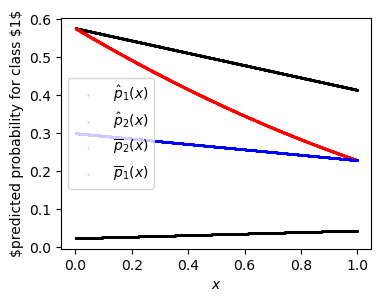

In [304]:
# plot the chosen random linear function for ensemble predictions
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.scatter(x_inst.squeeze(), preds_1[:, 0], label="$\hat{p}_1(x)$", alpha=0.1, color="black", s=1)
ax.scatter(x_inst.squeeze(), preds_2[:,  0], label="$\hat{p}_2(x)$", alpha=0.1, color="black", s=1)

# plot calibrated predictions for each setting
ax.scatter(x_inst.squeeze(), p_bar_1[:, 0], label="$\overline{p}_2(x)$", alpha=0.1, color="red", s=1)
ax.scatter(x_inst.squeeze(), p_bar_2[:, 0], label="$\overline{p}_1(x)$", alpha=0.1, color="blue", s=1)

ax.set_xlabel("$x$")
ax.set_ylabel("$predicted probability for class $1$")
plt.legend()



In [345]:
N_EPOCHS = 100
LR = 0.001
loss = loss_skce
BATCH_SIZE = 512

# first dataset: constant weights to learn
# sample labels from categorical distribution
y_labels_1 = np.apply_along_axis(multinomial_label_sampling, 1, p_bar_1)
y_labels_2 = np.apply_along_axis(multinomial_label_sampling, 1, p_bar_2)
y_labels_3 = np.apply_along_axis(multinomial_label_sampling, 1, p_bar_3)

# initialize datasets
dataset_1 = MLPDataset(x_inst, p_probs, y_labels_1)
dataset_2 = MLPDataset(x_inst, p_probs, y_labels_2)
dataset_3 = MLPDataset(x_inst, p_probs, y_labels_3)

# initialize models
model_1 = MLPCalW(
        in_channels=x_train.shape[1],
        out_channels=N_ENS,
        hidden_dim=N_HIDDEN,
        hidden_layers=N_HIDDEN_LAYERS,
        use_relu=True,
    )

model_2 = copy.deepcopy(model_1)
model_3 = copy.deepcopy(model_1)

model_1, loss_train_1, loss_val = train_mlp(
    model_1,
    dataset_train=dataset_1,
    n_epochs=N_EPOCHS,
    lr=LR,
    batch_size=BATCH_SIZE,
    loss=loss,
    every_n_epoch=10,
    optim=optimizer,
    shuffle=True
)

model_2, loss_train_2, loss_val = train_mlp(
    model_2,
    dataset_train=dataset_2,
    n_epochs=N_EPOCHS,
    lr=LR,
    batch_size=BATCH_SIZE,
    loss=loss,
    every_n_epoch=10,
    optim=optimizer,
)

model_3, loss_train_3, loss_val = train_mlp(
    model_3,
    dataset_train=dataset_3,
    n_epochs=N_EPOCHS,
    lr=LR,
    batch_size=BATCH_SIZE,
    loss=loss,
    every_n_epoch=10,
    optim=optimizer,
)


Epoch: 9 train loss: 1.9200327330756718e-07 val loss: None
Epoch: 19 train loss: 3.4594603434343066e-08 val loss: None
Epoch: 29 train loss: 6.68627507152686e-08 val loss: None
Epoch: 39 train loss: 3.9179935173994093e-08 val loss: None
Epoch: 49 train loss: 1.8849664930320475e-08 val loss: None
Epoch: 59 train loss: 2.595516508940854e-08 val loss: None
Epoch: 69 train loss: 2.904877593367305e-08 val loss: None
Epoch: 79 train loss: 1.625508792779608e-08 val loss: None
Epoch: 89 train loss: 5.414805240972452e-09 val loss: None
Epoch: 99 train loss: 1.2949615800679492e-09 val loss: None
Epoch: 9 train loss: 7.05667622072359e-08 val loss: None
Epoch: 19 train loss: 5.361431355960233e-08 val loss: None
Epoch: 29 train loss: 6.2772216104971594e-09 val loss: None
Epoch: 39 train loss: 9.431603814960555e-09 val loss: None
Epoch: 49 train loss: 1.2806281962868606e-08 val loss: None
Epoch: 59 train loss: 5.70621105939334e-09 val loss: None
Epoch: 69 train loss: 6.770412868039525e-09 val loss: 

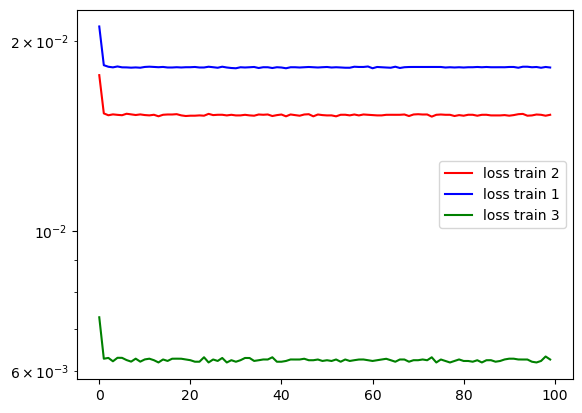

In [343]:
plt.plot(loss_train_1, color="red", label = "loss train 2")
plt.plot(loss_train_2, color="blue", label = "loss train 1")
plt.plot(loss_train_3, color="green", label = "loss train 3")

# log scale on y axis
plt.yscale("log")

plt.legend()

In [340]:
# compare predicted convex combinations with true ones
pred_weights_1 = model_1(torch.from_numpy(x_inst).float())
pred_weights_2 = model_2(torch.from_numpy(x_inst).float())
pred_weights_3 = model_3(torch.from_numpy(x_inst).float())

# compute calculated predictions
p_bar_pred_1 = calculate_pbar(pred_weights_1.detach().numpy(), p_probs)
p_bar_pred_2 = calculate_pbar(pred_weights_2.detach().numpy(), p_probs)
p_bar_pred_3 = calculate_pbar(pred_weights_3.detach().numpy(), p_probs)

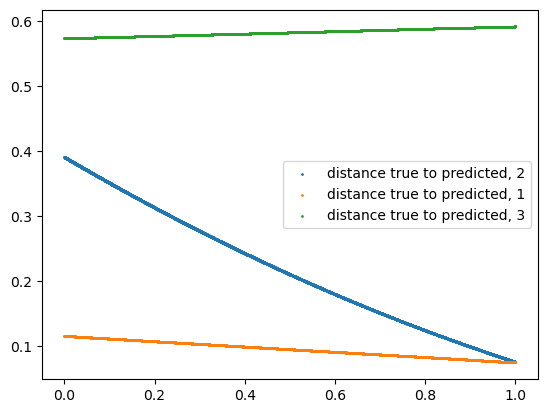

In [344]:
dist_1 = np.abs(p_bar_pred_1 - p_bar_1)
dist_2 = np.abs(p_bar_pred_2 - p_bar_2)
dist_3 = np.abs(p_bar_pred_3 - p_bar_3)

plt.scatter(x_inst.squeeze(), dist_1[:, 0], label="distance true to predicted, 2", s=1)
plt.scatter(x_inst.squeeze(), dist_2[:, 0], label="distance true to predicted, 1", s=1)
plt.scatter(x_inst.squeeze(), dist_3[:, 0], label="distance true to predicted, 3", s=1)

plt.legend()

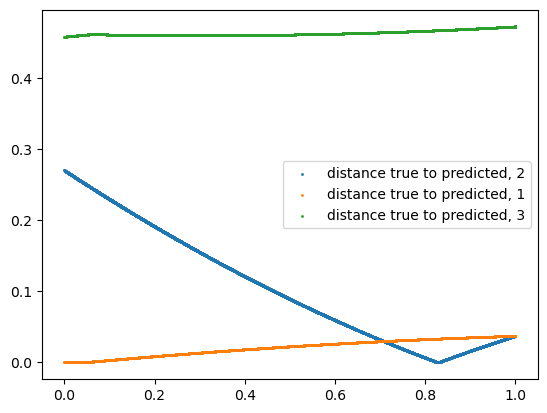

In [337]:
dist_1 = np.abs(p_bar_pred_1 - p_bar_1)
dist_2 = np.abs(p_bar_pred_2 - p_bar_2)
dist_3 = np.abs(p_bar_pred_3 - p_bar_3)

plt.scatter(x_inst.squeeze(), dist_1[:, 0], label="distance true to predicted, 2", s=1)
plt.scatter(x_inst.squeeze(), dist_2[:, 0], label="distance true to predicted, 1", s=1)
plt.scatter(x_inst.squeeze(), dist_3[:, 0], label="distance true to predicted, 3", s=1)

plt.legend()

In [14]:
# functions for generating (instance depnedent) predcitions in certain intervals

def generate_harmonic_series_ivl(x: np.ndarray, lower: float = 0.0, upper: float = 1.0, n_harmonics: int =5):
    """
    generates opints of a sum of harmonics in a given interval, given an array of instance values. 

    Parameters
    ----------
    x : np.ndarray
        array of shape (n_samples, n_features) containing the sampled instances
    lower : float
        lower bound of the interval
    upper : float
        upper bound of the interval
    n_harmonics : int
        number of harmonics to sum up
    
    Returns
    -------
    series : np.ndarray
        array of shape (n_samples, ) containing the generated points
    """

    n_points, _ = x.shape
    series = np.zeros(n_points)

    for k in range(n_harmonics):
        # sample coefficients in range [lower, upper]
        coef_1 = np.random.rand(1)*(upper - lower) + lower
        coef_2 = np.random.rand(1)*(upper - lower) + lower
        series += 1/((n_harmonics+1))*coef_1 * np.abs(np.sin(x[:,0]*2*np.pi*(k+1)))
        series += 1/((n_harmonics+1))*coef_2 * np.abs(np.cos(x[:,0]*2*np.pi*(k+1)))

    return series

series_1 = generate_harmonic_series_ivl(x_train, lower=0, upper=0.5, n_harmonics=10)
series_2 = gen_polynomial_predictions_ivl_binary(x_train, )


In [15]:
#plt.scatter(x_train, series_1, s=1)
for i in range(10):
    series_i_1 = generate_linear_fct_ivl(x_train, 0, 0.2)
    series_i_2 = generate_linear_fct_ivl(x_train, 0.4, 0.6)

    # generate harmonic series
    series_i_1_harm = generate_harmonic_series_ivl(x_train, 0.0, 0.2, 10)
    series_i_2_harm = generate_harmonic_series_ivl(x_train, 0.3, 0.5)

    # sample random weights
    weights_i = np.random.dirichlet(np.ones(2), size=1)[0]
    conv_comb_i = weights_i[0] * series_i_1 + weights_i[1] * series_i_2


    plt.scatter(x_train, series_i_1, s=1, alpha=0.2, color="lightgrey")
    plt.scatter(x_train, series_i_2, s=1, alpha=0.2, color="grey")
    plt.scatter(x_train, series_i_1_harm, s=1, alpha=0.2)
    plt.scatter(x_train, series_i_2_harm, s=1, alpha=0.2)
    plt.scatter(x_train, conv_comb_i, s=1, alpha=0.2, color="black")

NameError: name 'generate_linear_fct_ivl' is not defined

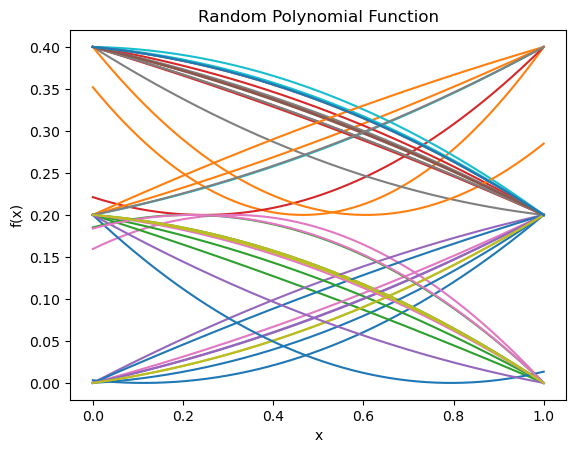

In [ ]:
def generate_random_polynomial_values(a, b, max_degree=5, n_points=1000):
    """
    Generate random polynomial function values evaluated over the unit interval.

    Parameters:
    - a, b: Desired range for function values.
    - max_degree: Maximum degree for the random polynomial.
    - n_points: Number of points in the unit interval for which to evaluate the function.

    Returns:
    - x_vals: Points in the unit interval.
    - y_vals: Corresponding function values.
    """
    
    # Decide on a degree for the polynomial (at least 1)
    #degree = np.random.randint(1, max_degree+1)
    degree = max_degree
    
    # Generate random coefficients for the polynomial
    coefficients = np.random.uniform(-1, 1, degree + 1)

    # Define the random polynomial function
    def f(x):
        return sum(coefficients[k] * (x ** k) for k in range(degree + 1))

    # Generate x values in the unit interval
    x_vals = np.linspace(0, 1, n_points)

    # Calculate y values for the polynomial
    y_vals = [f(x) for x in x_vals]

    # Find the existing range of y values
    min_val, max_val = min(y_vals), max(y_vals)

    # Scale and translate the function to fit within the range [a, b]
    y_vals = [a + (b - a) * (y - min_val) / (max_val - min_val) for y in y_vals]

    return x_vals, y_vals


for _ in range(20):
    a, b = 0, .2
    x_vals, y_vals = generate_random_polynomial_values(a, b, max_degree=2, n_points=1000)
    plt.plot(x_vals, y_vals)
    a, b = 0.2, .4
    x_vals, y_vals = generate_random_polynomial_values(a, b, max_degree=2, n_points=1000)
    plt.plot(x_vals, y_vals)

plt.plot(x_vals, y_vals)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Random Polynomial Function')
#plt.ylim([a, b])  # This ensures that the y-axis covers the interval [a, b]
plt.show()


In [ ]:
def p_binary_prob(x: np.ndarray, lower: float = 0, upper: float = 0.5):

    n_samples, n_features = x.shape
    preds = np.zeros((n_samples, 2))
    # sample random convex combinations of lower and upper interval values
    weights = np.random.dirichlet([1, 1], size=n_samples)
    preds[:, 0] = x[:, 0] * upper + (1-x[:, 0]) * lower
    preds[:, 1] = 1 - preds[:, 0]

    return preds

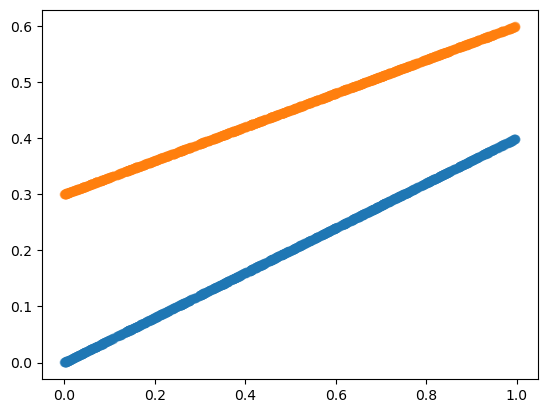

In [ ]:
preds_1 = p_binary_prob(x_train, upper=0.4)
preds_2 = p_binary_prob(x_train, lower=0.3, upper=0.6)

plt.plot(x_train.squeeze(), preds_1[:,0], 'o', alpha=0.5)
plt.plot(x_train.squeeze(), preds_2[:,0], 'o', alpha=0.5)

In [ ]:
p_1 = p_binary_prob(x_train, upper=0.5)
p_2 = p_binary_prob(x_train, upper=0.3)

In [ ]:
# new setting: simple linear functions for the binary case for en
weights = generate_weights_ens_dep(x_train, p_probs, deg=1)

Visualize the probabilitic predictions of the c.c. vs the actual labels

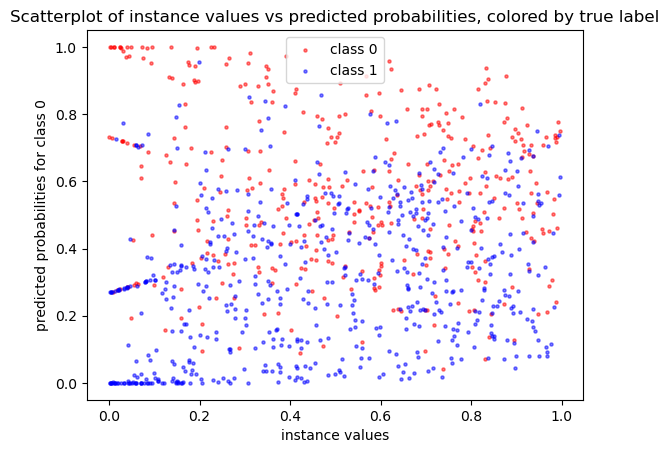

In [ ]:
fig, ax = plt.subplots()

# scatterplot of instance values vs predicted probabilities, colored by true label
ax.scatter(
    x_train[y_labels == 0],
    p_bar[:, 0][y_labels == 0],
    c="red",
    label="class 0",
    alpha=0.5,
    s=5,
)
ax.scatter(
    x_train[y_labels == 1],
    p_bar[:, 0][y_labels == 1],
    c="blue",
    label="class 1",
    alpha=0.5,
    s=5,
)
ax.set_xlabel("instance values")
ax.set_ylabel("predicted probabilities for class 0")
ax.set_title(
    "Scatterplot of instance values vs predicted probabilities, colored by true label"
)
plt.legend()


create datasets fro training and validation

In [ ]:
dataset_train = MLPDataset(x_train, p_probs, y_labels)
dataset_val = MLPDataset(x_val, p_probs_val, y_labels_val)

# dataloaders
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=BATCH_SIZE, shuffle=True)


Check loss on the "real", i.e. optimal convex combination. Note: The $L_p$ calibration error "vanishes" with increasing sample size. This has to be further analyzed.

In [ ]:
# chek "real" loss
# for fake labels
y_labels_fake = np.random.randint(0, 2, size=N_SAMPLES_TRAIN)
p_probs_fake = np.random.dirichlet([1]*2, size=(N_SAMPLES_TRAIN, N_ENS)) # TODO: check generation of probabilities

loss_real_l2 = loss_l2(
    torch.from_numpy(p_probs).float(),
    torch.from_numpy(weights).float(),
    torch.from_numpy(y_labels),
)
print(f"Real loss using L2: {loss_real_l2}")
loss_real_skce = loss_skce(
    torch.from_numpy(p_probs).float(),
    torch.from_numpy(weights).float(),
    torch.from_numpy(y_labels),
)
print(f"Real loss using SKCE: {loss_real_skce}")

loss_fake_l2 = loss_l2(
    torch.from_numpy(p_probs_fake).float(),
    torch.from_numpy(weights).float(),
    torch.from_numpy(y_labels),
)

loss_real_focal = loss_focal(
    torch.from_numpy(p_probs).float(),
    torch.from_numpy(weights).float(),
    torch.from_numpy(y_labels),
)
print(f"Real loss using focal: {loss_real_focal}")


Real loss using L2: nan
Real loss using SKCE: 1.2168914054200286e-07
Real loss using focal: 0.029029427096247673


#### Train with $L_2$ error as training loss

In [ ]:
# train 10 times, save weights
# train model
weights_preds = []
loss = loss_focal


for n in range(N_ITER):
    model = MLPCalW(
        in_channels=x_train.shape[1],
        out_channels=N_ENS,
        hidden_dim=N_HIDDEN,
        hidden_layers=N_HIDDEN_LAYERS,
        use_relu=False,
    )

    model, loss_train, loss_val = train_mlp(
        model,
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        n_epochs=N_EPOCHS,
        lr=LR,
        batch_size=BATCH_SIZE,
        loss=loss,
        every_n_epoch=10,
        optim=optimizer,
    )

    weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()
    weights_preds.append(weights_pred)


Epoch: 9 train loss: 0.027594922110438347 val loss: 0.02703809179365635
Epoch: 19 train loss: 0.02751665934920311 val loss: 0.027075201272964478
Epoch: 29 train loss: 0.027451977133750916 val loss: 0.027112264186143875
Epoch: 39 train loss: 0.02739953249692917 val loss: 0.02714824303984642
Epoch: 49 train loss: 0.02735750563442707 val loss: 0.027182457968592644
Epoch: 59 train loss: 0.027324026450514793 val loss: 0.0272145327180624
Epoch: 69 train loss: 0.027297433465719223 val loss: 0.02724430523812771
Epoch: 79 train loss: 0.02727632038295269 val loss: 0.027271749451756477
Epoch: 89 train loss: 0.027259545400738716 val loss: 0.02729693055152893
Epoch: 99 train loss: 0.027246205136179924 val loss: 0.027319952845573425
Epoch: 9 train loss: 0.0289923008531332 val loss: 0.026908252388238907
Epoch: 19 train loss: 0.02882983349263668 val loss: 0.02690989337861538
Epoch: 29 train loss: 0.028678180649876595 val loss: 0.026914196088910103
Epoch: 39 train loss: 0.02853761799633503 val loss: 0.

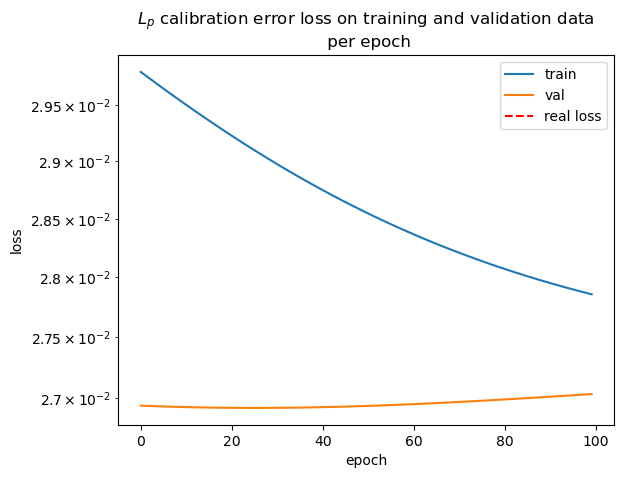

In [ ]:
fig, ax = plt.subplots()

plt.plot(loss_train, label="train")
plt.plot(loss_val, label="val")
plt.title("$L_p$ calibration error loss on training and validation data \n per epoch")
#ax.set_yscale('log')
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# log scale of y axis
ax.set_yscale("log")
# horizontal line with real loss
plt.axhline(loss_real_l2, color="red", label="real loss", linestyle="--")
plt.legend()

#### analyse jensen shannon divergence between real and predicted weights, as well as real and predicted probabilities during training


In [ ]:
weights_preds = []
dists_weights_per_epoch = np.zeros((N_ITER, N_EPOCHS))
dists_probs_per_epoch = np.zeros((N_ITER, N_EPOCHS))

loss = loss_focal


for n in range(1):
    model = MLPCalW(
        in_channels=x_train.shape[1],
        out_channels=N_ENS,
        hidden_dim=N_HIDDEN,
        hidden_layers=N_HIDDEN_LAYERS,
        use_relu=True,
    )

    # train loop
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_train = np.zeros(N_EPOCHS)
    loss_val = np.zeros(N_EPOCHS)

    for epoch in range(N_EPOCHS):
        model.train()
        model, loss_epoch_train, loss_epoch_val = train_one_epoch(model, loss, dataloader_train,
                                                                  optimizer, dataloader_val)
        loss_train[epoch] = loss_epoch_train
        loss_val[epoch] = loss_epoch_val

        weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()
        pred_p_bar = calculate_pbar(weights_pred, p_probs)
        dists_weights_per_epoch[n, epoch] = np.linalg.norm(weights_pred - weights)
        dist_preds = jensenshannon(pred_p_bar[:,0], p_bar[:,0])
        print(f"Epoch {epoch}, dist: {dist_preds}")
        dists_probs_per_epoch[n, epoch] = dist_preds

    weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()
    weights_preds.append(weights_pred)



Epoch 0, dist: 0.06823647524216937
Epoch 1, dist: 0.06798968996214803
Epoch 2, dist: 0.0677512918623673
Epoch 3, dist: 0.06752141339855447
Epoch 4, dist: 0.06730019170040048
Epoch 5, dist: 0.0670877513897527
Epoch 6, dist: 0.06688422627093225
Epoch 7, dist: 0.06668974343955741
Epoch 8, dist: 0.06650443316260146
Epoch 9, dist: 0.06632842562716795
Epoch 10, dist: 0.06616185280199545
Epoch 11, dist: 0.0660048399974949
Epoch 12, dist: 0.06585751165109145
Epoch 13, dist: 0.06571996947623032
Epoch 14, dist: 0.06559230328719026
Epoch 15, dist: 0.06547456859292149
Epoch 16, dist: 0.06536680183077856
Epoch 17, dist: 0.06526901328168375
Epoch 18, dist: 0.06518119990449132
Epoch 19, dist: 0.06510333714915412
Epoch 20, dist: 0.06503539847253165
Epoch 21, dist: 0.06497734464371674
Epoch 22, dist: 0.06492913804267636
Epoch 23, dist: 0.06489073300661599
Epoch 24, dist: 0.06486208324120225
Epoch 25, dist: 0.06484314120606353
Epoch 26, dist: 0.06483385368254191
Epoch 27, dist: 0.06483416318972983
Epoch

compare KL-divergence between predictions learned by the model and "real" predictions:

In [ ]:
pred_weights = model(torch.from_numpy(x_train).float()).detach().numpy()
pred_p_bar = calculate_pbar(pred_weights, p_probs)

jensenshannon(pred_p_bar[:, 0], p_bar[:, 0])
jensenshannon(pred_weights, weights)

array([0.00437367, 0.00940127])

Text(0, 0.5, 'distance')

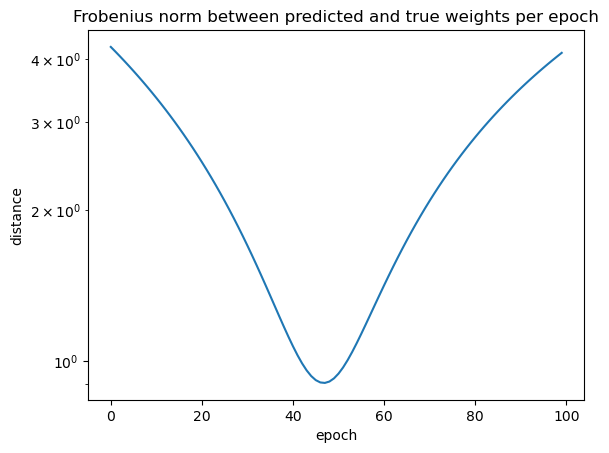

In [ ]:
# plot distances (log y scale)
fig, ax = plt.subplots()
ax.plot(dists_weights_per_epoch.T)
ax.set_title("Frobenius norm between predicted and true weights per epoch")
ax.set_yscale("log")
ax.set_xlabel("epoch")
ax.set_ylabel("distance")

Text(0, 0.5, 'distance')

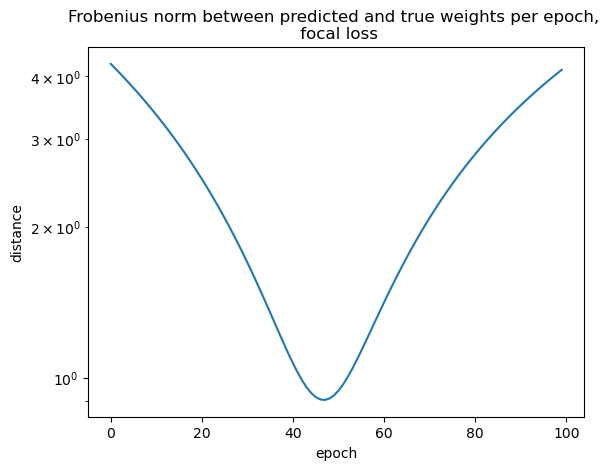

In [ ]:
# plot distances (log y scale)
fig, ax = plt.subplots()
ax.plot(dists_weights_per_epoch.T)
ax.set_title("Frobenius norm between predicted and true weights per epoch, \n focal loss")
ax.set_yscale("log")
ax.set_xlabel("epoch")
ax.set_ylabel("distance")

Text(0, 0.5, 'distance')

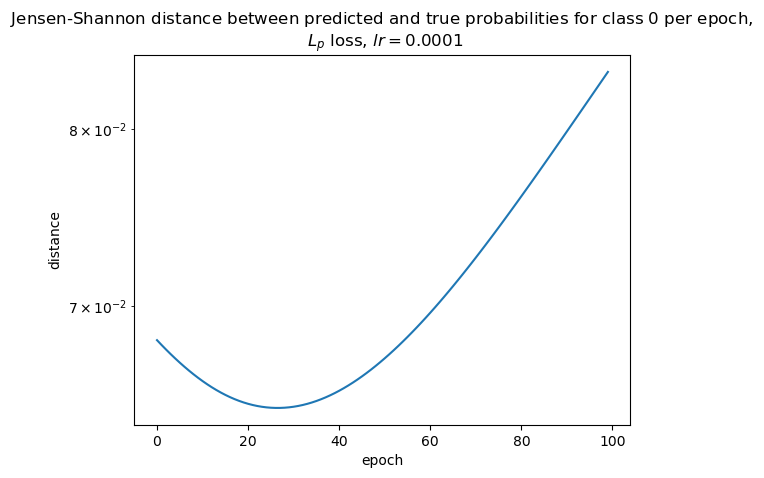

In [ ]:
# plot jensen shannon distances (log y scale)
fig, ax = plt.subplots()
ax.plot(dists_probs_per_epoch.T)
ax.set_title("Jensen-Shannon distance between predicted and true probabilities for class $0$ per epoch, \n $L_p$ loss, $lr=0.0001$")
ax.set_yscale("log")
ax.set_xlabel("epoch")
ax.set_ylabel("distance")


Text(0, 0.5, 'distance')

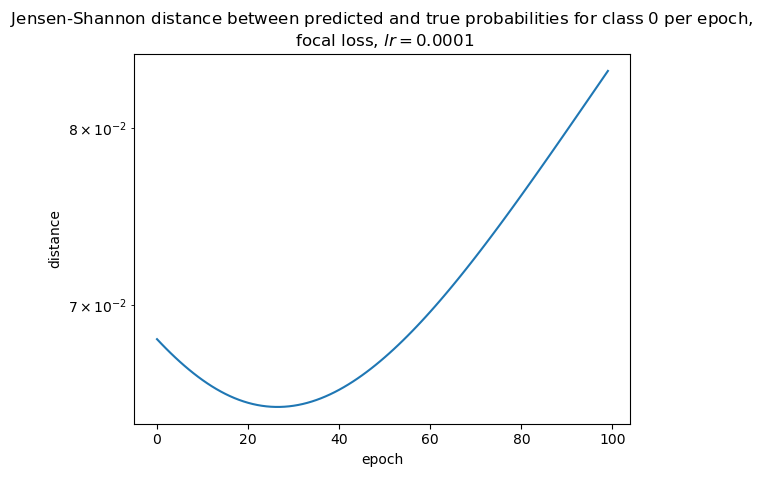

In [ ]:
# plot jensen shannon distances (log y scale)
fig, ax = plt.subplots()
ax.plot(dists_probs_per_epoch.T)
ax.set_title("Jensen-Shannon distance between predicted and true probabilities for class $0$ per epoch, \n focal loss, $lr=0.0001$")
ax.set_yscale("log")
ax.set_xlabel("epoch")
ax.set_ylabel("distance")

JEnsen Shannon real and pred: 0.0043736693335577675


IndexError: list index out of range

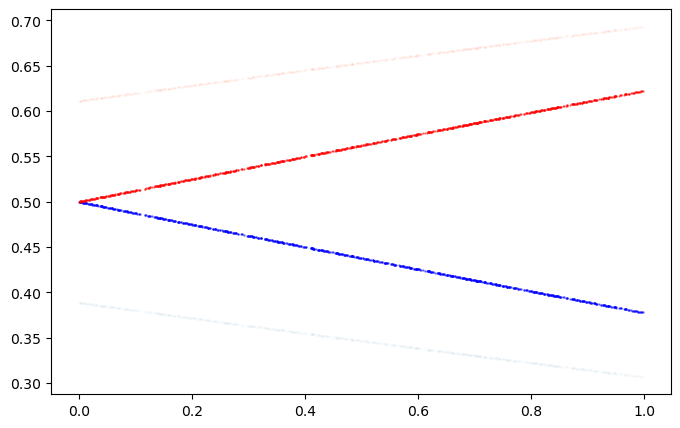

In [ ]:
color_iter = iter(plt.cm.rainbow(np.linspace(0, 1, N_ENS)))


weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x = x_train[:, 0]
"""
for n_ens in range(N_ENS):
    color = next(color_iter)
    ax.scatter(x, weights[:, n_ens], s=0.5, alpha=0.5, c=color, label = f"$\lambda_{n+1}$")

    for n in range(N_ITER):
        ax.scatter(x, weights_preds[n][:, n_ens], s=0.1,c=color, alpha=0.1)
"""
ax.scatter(x, weights[:, 0], s=0.5, alpha=0.5, c="blue", label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5,alpha=0.5, c="red", label = "$\lambda_2$")

# make linestyle dashed
for n in range(N_ITER):
    ax.scatter(x, weights_preds[n][:, 0], s=0.1,c="lightblue", alpha=0.1)
    ax.scatter(x, weights_preds[n][:, 1], s=0.1, alpha=0.1,c="lightsalmon")
    print(f"JEnsen Shannon real and pred: {jensenshannon(weights[:, 0], weights_preds[n][:, 0])}")

plt.legend()
plt.title("Intially chosen (red, blue) and learned (faded) weight coefficients of \n first and second ensemble member per instance, \n focal loss")

TypeError: title() missing 1 required positional argument: 'label'

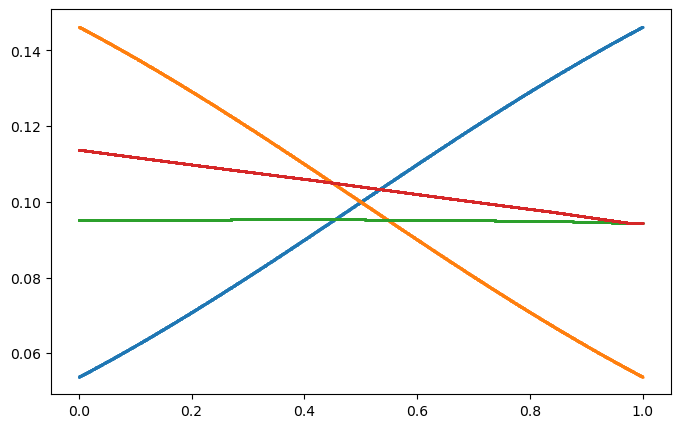

In [ ]:
weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x = x_train[:, 0]
ax.scatter(x, weights[:, 0], s=0.5, alpha=0.5, label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5,alpha=0.5, label = "$\lambda_2$")

#ax.scatter(x, weights_pred[:, 2], s=0.5, label = "$\hat{\lambda}_3$")
# make linestyle dashed
ax.scatter(x, weights_pred[:, 0], s=0.5, label = "$\hat{\lambda}_1$")
ax.scatter(x, weights_pred[:, 1], s=0.5, label = "$\hat{\lambda}_2$")

plt.title()
plt.legend()

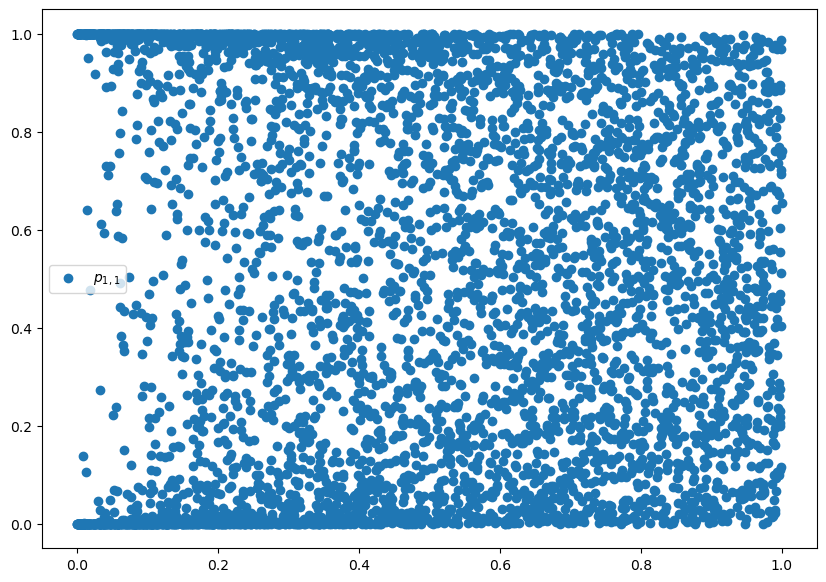

In [ ]:
# plot predictions anc convex combination
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
x = x_train[:, 0]
ax.scatter(x, p_probs[:, 0, 0], label = "$p_{1,1}$")
#ax.plot(x, p_probs[:, 0, 1],label = "$p_{1,2}$")
#ax.scatter(x, p_probs[:, 1, 0], s=0.1, label = "$p_2$")
#ax.plot(p_probs[:, 1, 0], label = "$p_2$")
#ax.plot(p_bar[:, 0], label = "$\hat{p}$")

plt.legend()

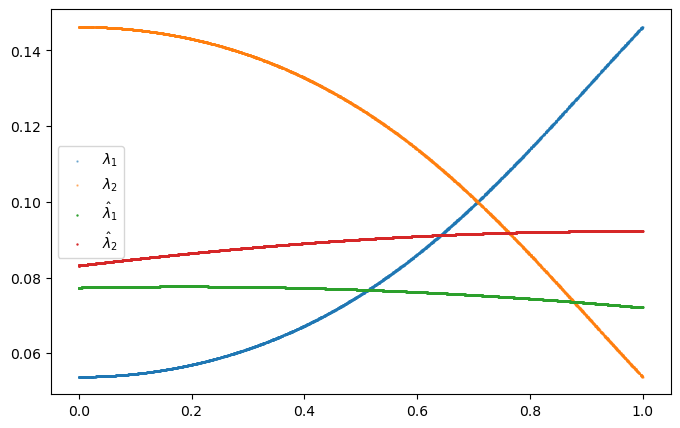

In [ ]:
weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x = x_train[:, 0]
ax.scatter(x, weights[:, 0], s=0.5, alpha=0.5, label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5,alpha=0.5, label = "$\lambda_2$")

#ax.scatter(x, weights_pred[:, 2], s=0.5, label = "$\hat{\lambda}_3$")
# make linestyle dashed
ax.scatter(x, weights_pred[:, 0], s=0.5, label = "$\hat{\lambda}_1$")
ax.scatter(x, weights_pred[:, 1], s=0.5, label = "$\hat{\lambda}_2$")

plt.legend()

In [ ]:
loss_real = loss(torch.from_numpy(p_probs).float(), torch.from_numpy(weights).float(), torch.from_numpy(y_labels))

In [ ]:
loss_real

tensor(4.3365e-12)

In [ ]:
summary(model, input_size=x_train.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              64
            Linear-2                   [-1, 32]           1,056
            Linear-3                   [-1, 10]             330
           Softmax-4                   [-1, 10]               0
Total params: 1,450
Trainable params: 1,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


IndexError: list index out of range

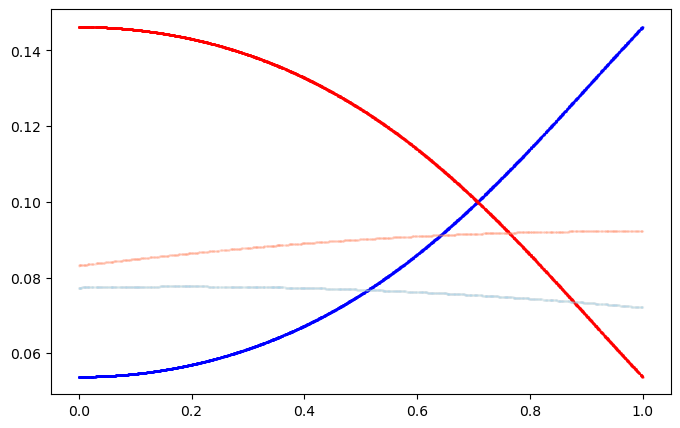

In [ ]:
weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x = x_train[:, 0]
ax.scatter(x, weights[:, 0], s=0.5, alpha=0.5, c="blue", label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5,alpha=0.5, c="red", label = "$\lambda_2$")

#ax.scatter(x, weights_pred[:, 2], s=0.5, label = "$\hat{\lambda}_3$")
# make linestyle dashed
for n in range(10):
    ax.scatter(x, weights_preds[n][:, 0], s=0.1,c="lightblue", alpha=0.1)
    ax.scatter(x, weights_preds[n][:, 1], s=0.1, alpha=0.1,c="lightsalmon")

plt.legend()

In [ ]:
# calculate skceul loss
loss_skce_real = loss_skce(torch.from_numpy(p_probs).float(), torch.from_numpy(weights).float(), torch.from_numpy(y_labels))
loss_skce_fake = loss_skce(torch.from_numpy(p_probs).float(), torch.from_numpy(weights_pred).float(), torch.from_numpy(y_labels))

In [ ]:
loss_skce_real

tensor(8.4743e-08)

In [ ]:
loss_skce_fake

tensor(4.2237e-08)

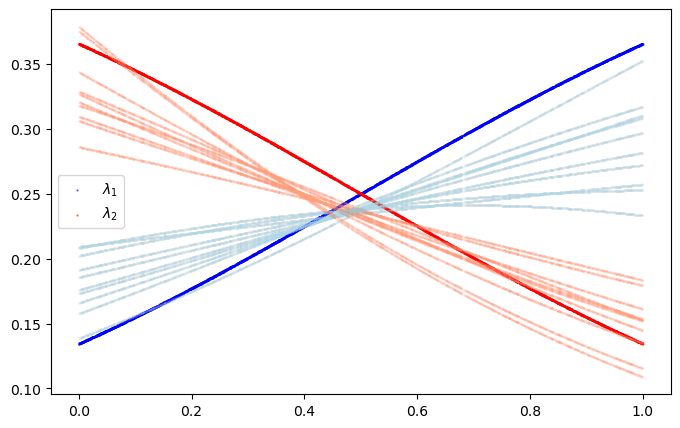

In [ ]:
weights_pred = model(torch.from_numpy(x_train).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x = x_train[:, 0]
ax.scatter(x, weights[:, 0], s=0.5, alpha=0.5, c="blue", label = "$\lambda_1$")
ax.scatter(x, weights[:, 1],s=0.5,alpha=0.5, c="red", label = "$\lambda_2$")

#ax.scatter(x, weights_pred[:, 2], s=0.5, label = "$\hat{\lambda}_3$")
# make linestyle dashed
for n in range(10):
    ax.scatter(x, weights_preds[n][:, 0], s=0.1,c="lightblue", alpha=0.1)
    ax.scatter(x, weights_preds[n][:, 1], s=0.1, alpha=0.1,c="lightsalmon")

plt.legend()

In [ ]:
# calculate skceul loss
loss_skce_real = loss_skce(torch.from_numpy(p_probs).float(), torch.from_numpy(weights).float(), torch.from_numpy(y_labels))
print(loss_skce_real)
for n in range(N_ITER):
    loss_skce_fake = loss_skce(torch.from_numpy(p_probs).float(), torch.from_numpy(weights_preds[n]).float(), torch.from_numpy(y_labels))
    print(loss_skce_fake)

tensor(1.8986e-07)
tensor(2.1650e-07)
tensor(1.9830e-07)
tensor(2.1665e-07)
tensor(2.1134e-07)
tensor(1.7260e-07)
tensor(1.9725e-07)
tensor(1.9353e-07)
tensor(1.8657e-07)
tensor(2.0718e-07)
tensor(1.7832e-07)
